In [1]:
#Бібліотека для роботи з розархіватором
!pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import os
import cv2
import numpy as np
import pandas as pd
import rarfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import drive
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

Імпортуємо підключення до Google drive, після чого назначаємо папку для скачування архіву в якому находяться зображення поділені за класами. Потім розархівовуємо наш архів.



In [3]:
#Конект до бази даних
from google.colab import drive
drive.mount('/content/gdrive')

rar_file_path = '/content/gdrive/MyDrive/Data/color.rar'

output_dir = '/content/data'

unrar_path = os.path.join(output_dir, "")
#Розархівовування
with rarfile.RarFile(rar_file_path) as rf:
    rf.extractall(output_dir)


Mounted at /content/gdrive


Прописуємо цикл в якому добавляємо зображення в файл data.csv поділяючи їх на класи

In [4]:
# Шлях до зображень
data_dir = '/content/data/color'

# Створення генератора даних
datagen = ImageDataGenerator(rescale=1./255)

# Параметри генератора даних
batch_size = 32
img_size = (224, 224)

# Генерация данных и сохранение в файл CSV
columns = ['filepaths', 'labels']
df = pd.DataFrame(columns=columns)

# Цикл в якому ми записуємо зображення 
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        filepaths = []
        labels = []

        for file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, file)
            filepaths.append(image_path)
            labels.append(class_name)

        data = {'filepaths': filepaths, 'labels': labels}
        class_df = pd.DataFrame(data)

        df = pd.concat([df, class_df], ignore_index=True)

df.to_csv('/content/data.csv', index=False)

Виводимо інформацію про створений датасет

In [5]:
data = pd.read_csv('/content/data.csv') # Навчання моделі
class_counts = data['labels'].value_counts() # Виписуємо класи
print("Повна інформація про класи та кількість елементів:")
print(class_counts)

Повна інформація про класи та кількість елементів:
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape

Виводимо діаграмою

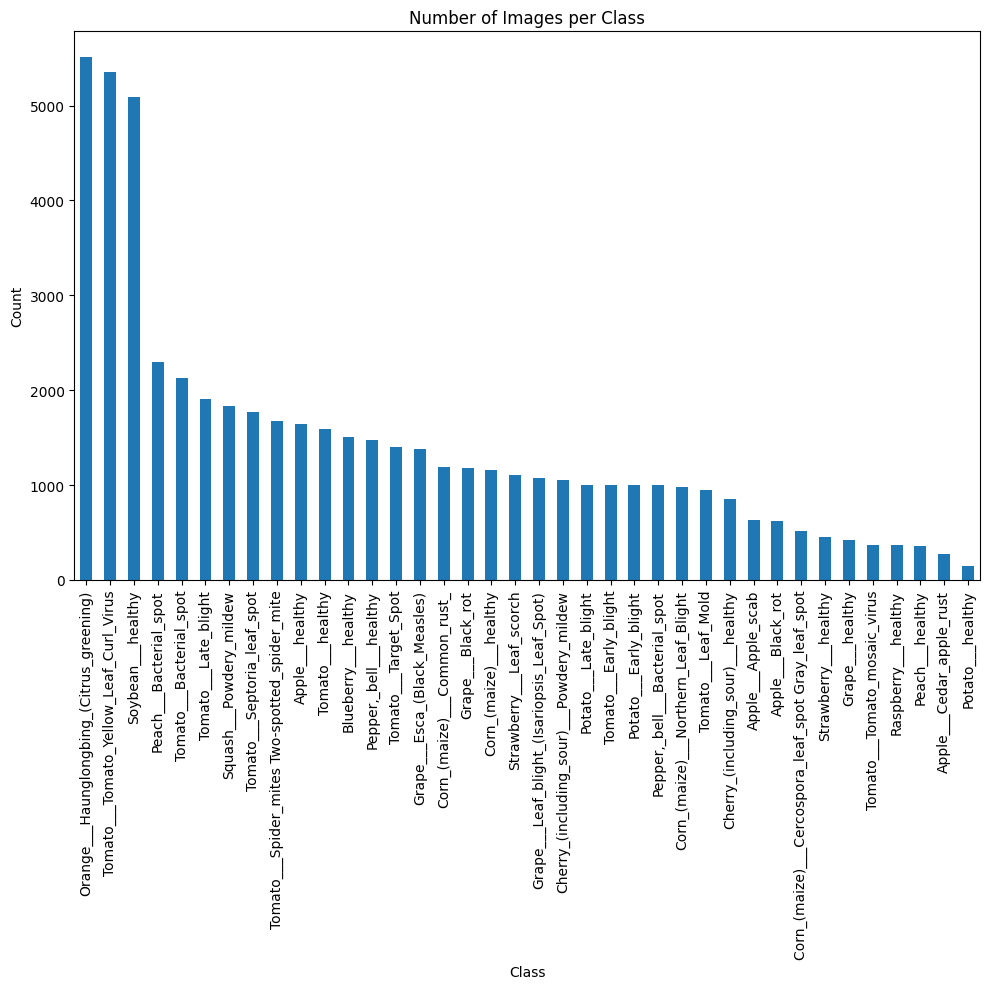

In [6]:
# Загрузка даних з файла data.csv
df = pd.read_csv('/content/data.csv')

# Підрахунок унікальних класів для кожного зображення
class_counts = df['labels'].value_counts()

# Вивід графіка
plt.figure(figsize=(10, 10))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/content/class_counts.png')  # Збереження графіку
plt.show()

Створення збалансованого датасету

In [7]:
data_dir = '/content/data/color'

datagen = ImageDataGenerator(rescale=1./255)

# Параметри генератора даних
batch_size = 32
img_size = (224, 224)

# Генерація даних
columns = ['filepaths', 'labels']
df = pd.DataFrame(columns=columns)

max_samples = 0  # Максимальна кількість зразків класу

# Знаходження максимальної кількості зразків в класі
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        num_samples = len(os.listdir(class_dir))
        if num_samples > max_samples:
            max_samples = num_samples

# Надвибірка (oversampling) для збалансування датасету
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        filepaths = []
        labels = []

        # Збалансування кількості зображень в класі
        class_samples = os.listdir(class_dir)
        oversampled_samples = resample(class_samples, replace=True, n_samples=max_samples)

        for file in oversampled_samples:
            image_path = os.path.join(class_dir, file)
            filepaths.append(image_path)
            labels.append(class_name)

        data = {'filepaths': filepaths, 'labels': labels}
        class_df = pd.DataFrame(data)

        df = pd.concat([df, class_df], ignore_index=True)

df.to_csv('/content/data_balanced.csv', index=False)

Виводимо збалансовані данні

In [8]:
data = pd.read_csv('/content/data_balanced.csv') # Навчання моделі
class_counts = data['labels'].value_counts() # Виписуємо класи
print("Повна інформація про класи та кількість елементів:")
print(class_counts)

Повна інформація про класи та кількість елементів:
Squash___Powdery_mildew                               5507
Grape___healthy                                       5507
Pepper,_bell___healthy                                5507
Tomato___Early_blight                                 5507
Tomato___Spider_mites Two-spotted_spider_mite         5507
Grape___Esca_(Black_Measles)                          5507
Grape___Black_rot                                     5507
Potato___healthy                                      5507
Apple___Cedar_apple_rust                              5507
Peach___healthy                                       5507
Peach___Bacterial_spot                                5507
Blueberry___healthy                                   5507
Pepper,_bell___Bacterial_spot                         5507
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)            5507
Apple___healthy                                       5507
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot    5507
Tomat

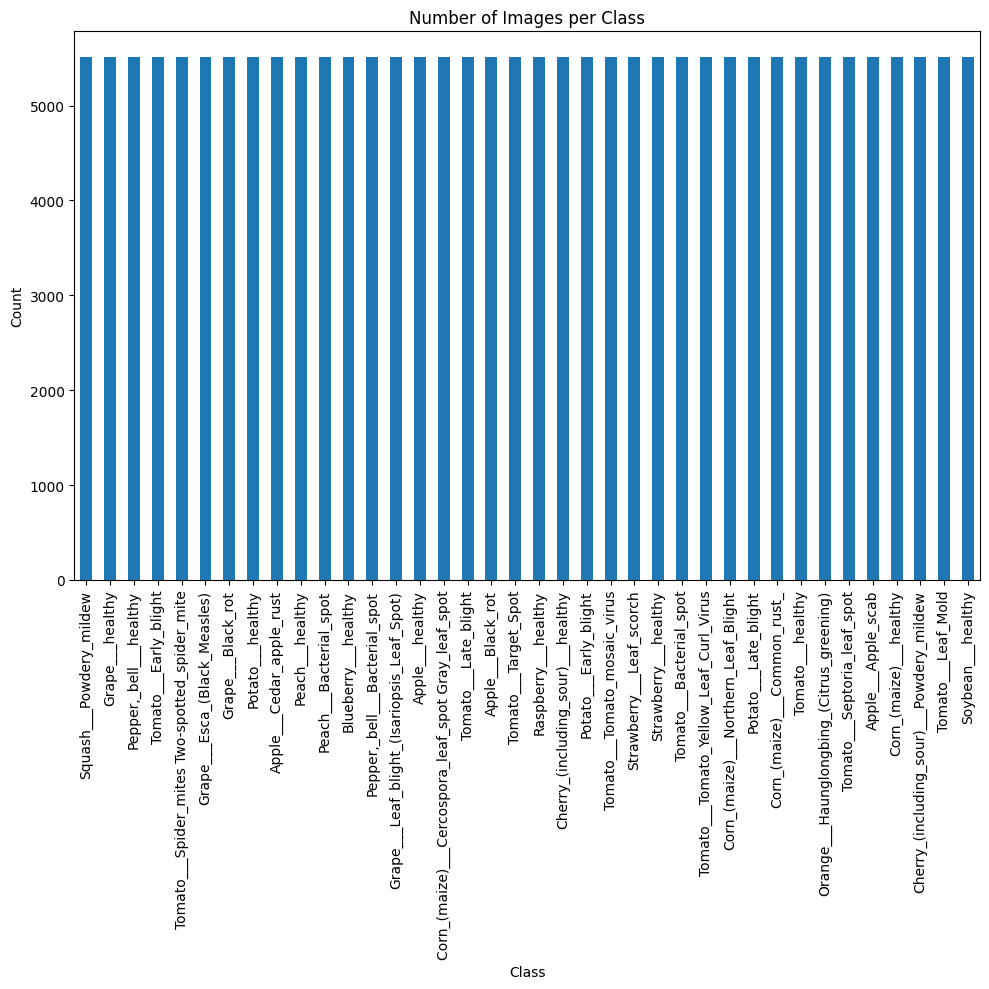

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/data_balanced.csv')

class_counts = df['labels'].value_counts()

plt.figure(figsize=(10, 10))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/content/class_counts_balanced.png') 
plt.show()

Приклад аугментації даних

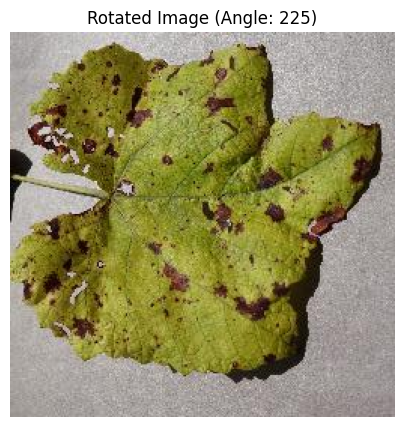

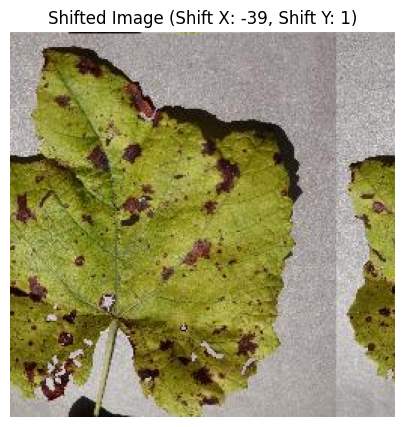

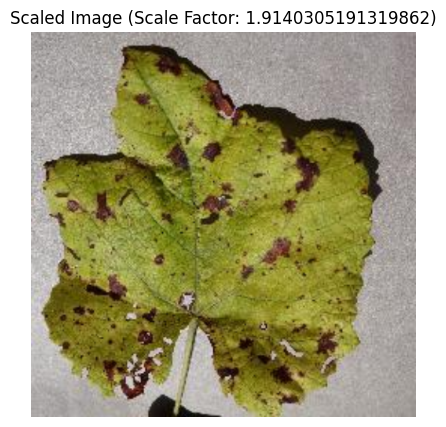

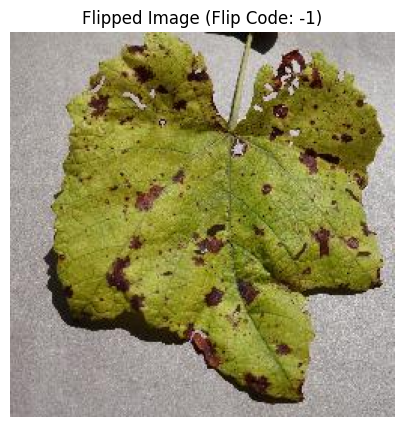

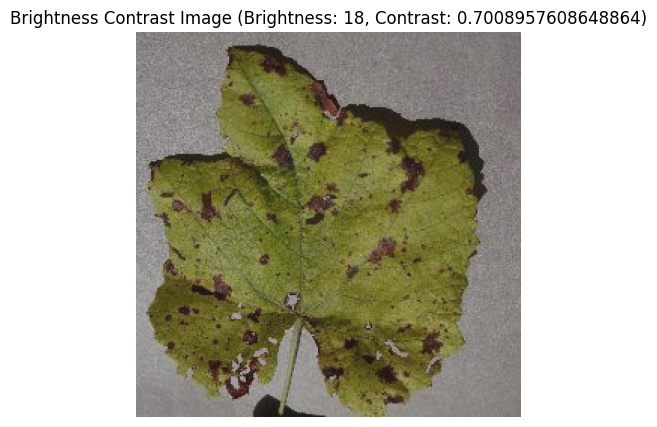

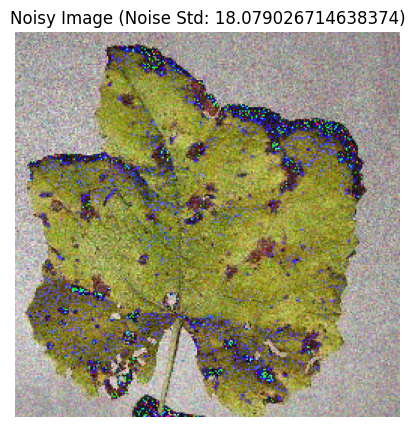

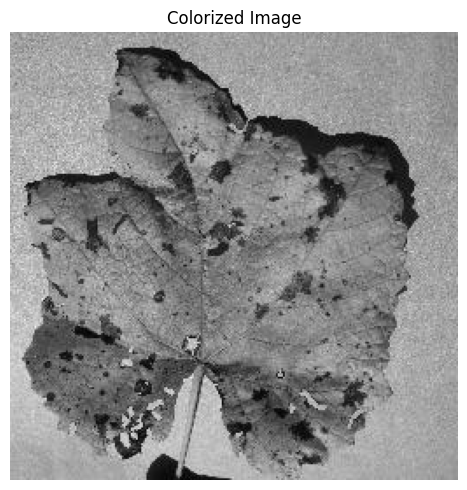

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Завантаження зображення
image = cv2.imread('/content/test_image_1.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертування з BGR в RGB

# Функція для відображення графіка зображення
def show_image_as_plot(image, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# 1. Обертання
angle = np.random.randint(0, 360)
rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
show_image_as_plot(rotated_image, f'Rotated Image (Angle: {angle})')

# 2. Зсув
shift_x = np.random.randint(-50, 50)
shift_y = np.random.randint(-50, 50)
shifted_image = np.roll(image, shift_x, axis=1)
shifted_image = np.roll(shifted_image, shift_y, axis=0)
show_image_as_plot(shifted_image, f'Shifted Image (Shift X: {shift_x}, Shift Y: {shift_y})')

# 3. Масштабування
scale_factor = np.random.uniform(0.5, 2.0)
scaled_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
show_image_as_plot(scaled_image, f'Scaled Image (Scale Factor: {scale_factor})')

# 4. Віддзеркалення
flip_code = np.random.randint(-1, 2)
flipped_image = cv2.flip(image, flip_code)
show_image_as_plot(flipped_image, f'Flipped Image (Flip Code: {flip_code})')

# 5. Зміна яскравості і контрастності
brightness = np.random.randint(-50, 50)
contrast = np.random.uniform(0.5, 1.5)
brightness_contrast_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
show_image_as_plot(brightness_contrast_image, f'Brightness Contrast Image (Brightness: {brightness}, Contrast: {contrast})')

# 6. Зашумлення
noise_std = np.random.uniform(0, 25)
noisy_image = np.uint8(image + np.random.normal(0, noise_std, image.shape))
show_image_as_plot(noisy_image, f'Noisy Image (Noise Std: {noise_std})')

# 7. Зміна кольорової гами
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
colorized_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
show_image_as_plot(colorized_image, 'Colorized Image')

# Відображення всіх графіків
plt.tight_layout()
plt.show()

Створюємо тренування моделі, прописуючи кількість шарів, налаштування 

Found 167412 validated image filenames belonging to 38 classes.
Found 20927 validated image filenames belonging to 38 classes.
Found 20927 validated image filenames belonging to 38 classes.
Epoch 1/10
4186/4186 [==============================] - 562s 131ms/step - loss: 0.4613 - accuracy: 0.8615 - val_loss: 0.1664 - val_accuracy: 0.9457
Epoch 2/10
4186/4186 [==============================] - 553s 132ms/step - loss: 0.1055 - accuracy: 0.9667 - val_loss: 0.0837 - val_accuracy: 0.9728
Epoch 3/10
4186/4186 [==============================] - 549s 131ms/step - loss: 0.0684 - accuracy: 0.9779 - val_loss: 0.0535 - val_accuracy: 0.9827
Epoch 4/10
4186/4186 [==============================] - 546s 130ms/step - loss: 0.0508 - accuracy: 0.9842 - val_loss: 0.0886 - val_accuracy: 0.9761
Epoch 5/10
4186/4186 [==============================] - 529s 126ms/step - loss: 0.0416 - accuracy: 0.9873 - val_loss: 0.0500 - val_accuracy: 0.9855
Epoch 6/10
4186/4186 [==============================] - 539s 129ms/ste

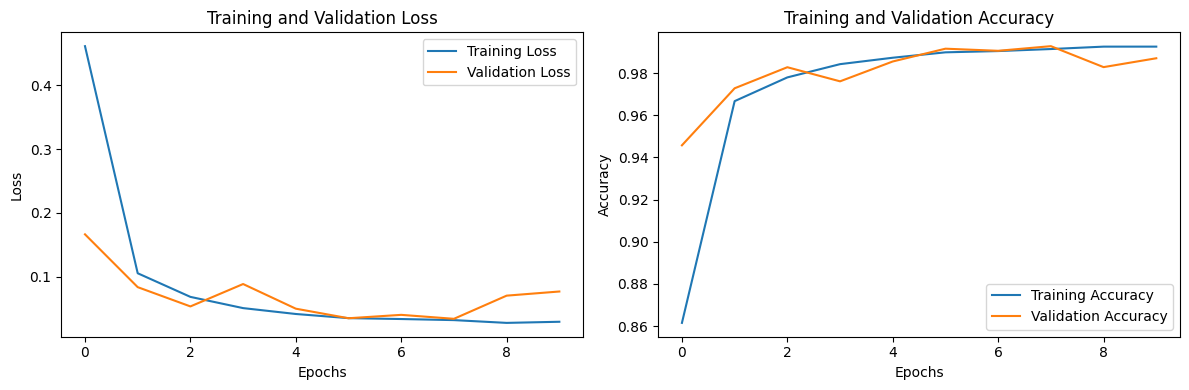

524/524 [==============================] - 53s 102ms/step - loss: 0.0595 - accuracy: 0.9882
Test accuracy: 0.9881970882415771


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка даних
data = pd.read_csv('/content/data_balanced.csv')
train_df, test_df = train_test_split(data, test_size=0.2, random_state=123)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=123)

# Опрацювання даних
img_size = (224, 224)
batch_size = 40
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', shuffle=True, batch_size=batch_size
)
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', shuffle=True, batch_size=batch_size
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', shuffle=False, batch_size=batch_size
)

# Оприділення моделі
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(38, activation='softmax')
])

# Компіляція і навчання моделі
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator, validation_data=valid_generator, epochs=10,
    callbacks=[keras.callbacks.History()]
)

# Вивід графіків навчання
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Збереження навченої моделі
model.save('trained_model.h5')

# Оцінка моделі
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Виведення інформації про модель

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

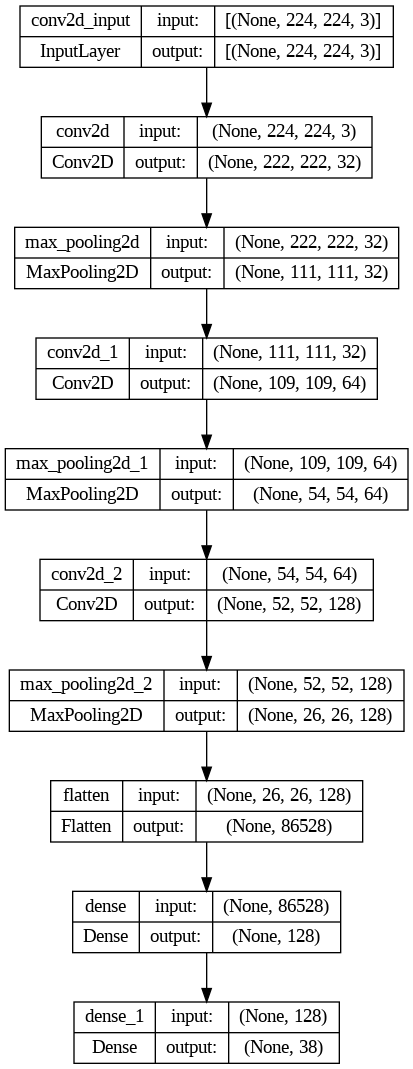

In [34]:
# Завантаження готової моделі
model = tf.keras.models.load_model('/content/trained_model.h5')

# Виведення повної інформації про модель
model.summary()

# Побудова схеми архітектури моделі на графіку
plot_model(model, to_file='model_architecture.png', show_shapes=True)

Код для візуалізації виділення ознак при проходженні зображення по кожному шарі натренованій моделі

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
1/1 [==============================] - 0s 396ms/step
Індекс класу: 4
Мітка класу: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight

<ipython-input-30-fe4d8f7deda6>:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


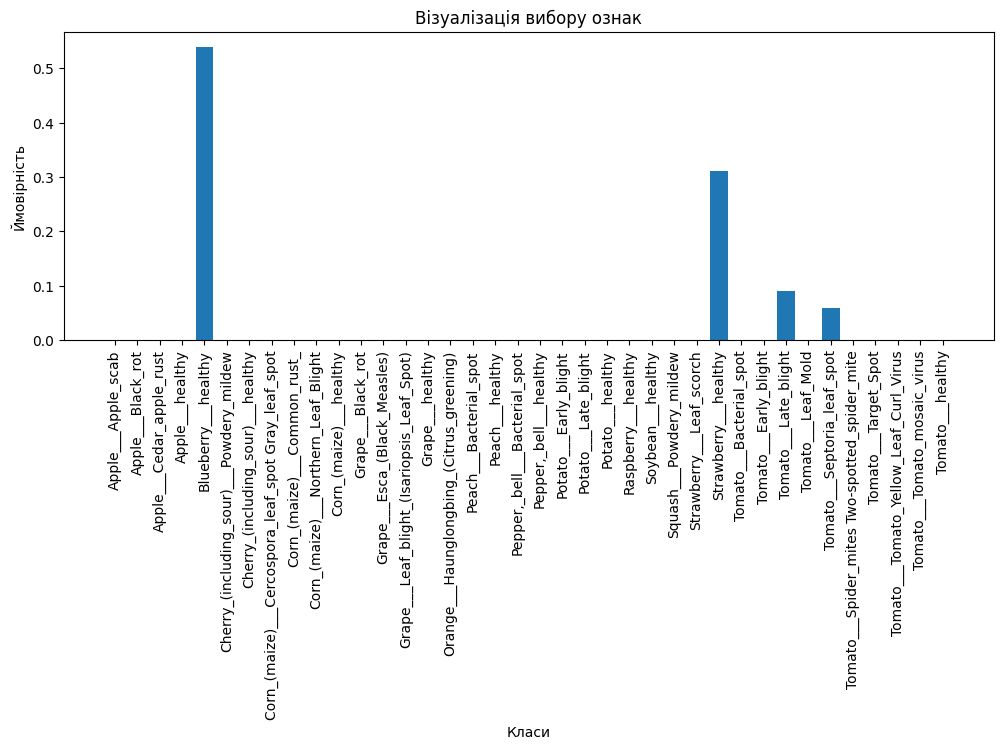

1/1 [==============================] - 0s 125ms/step


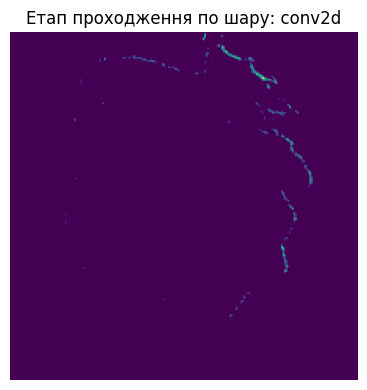

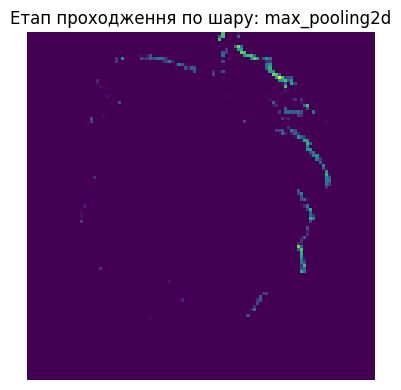

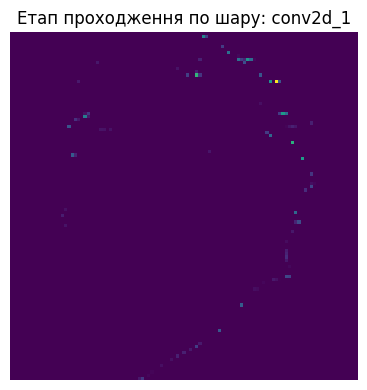

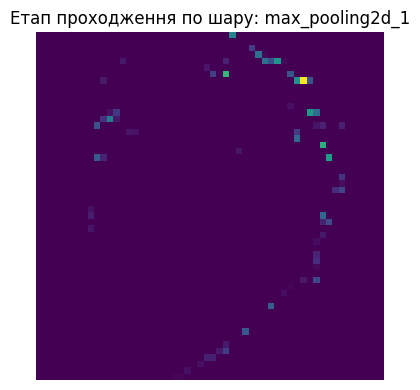

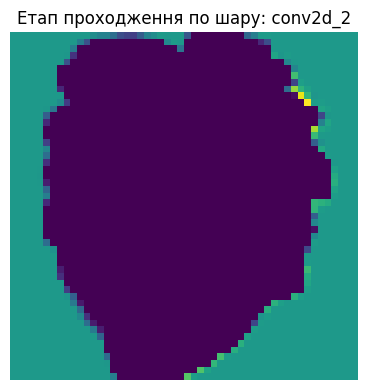

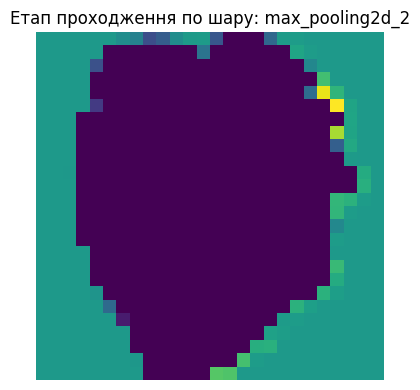

In [30]:
# Загрузка даних
data = pd.read_csv('/content/data.csv')
train_df, test_df = train_test_split(data, test_size=0.2, random_state=123)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=123)

# Попередня обробка даних
img_size = (224, 224)
batch_size = 40
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', shuffle=True, batch_size=batch_size
)
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', shuffle=True, batch_size=batch_size
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', shuffle=False, batch_size=batch_size
)

# Шлях до зображення, яке потрібно перевірити
image_path = "/content/test_image_2.jpg"

# Завантаження зображення та попередня обробка
img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Нормалізація значень пікселів

# Завантаження навченої моделі
model = keras.models.load_model("/content/trained_model.h5")

# Перевірка вхідного зображення
predictions = model.predict(img_array)
class_index = np.argmax(predictions[0])
class_label = train_generator.class_indices

# Вивід результату
print("Індекс класу:", class_index)
print("Мітка класу:", class_label)

# Візуалізація вибору ознак
plt.figure(figsize=(12, 4))
plt.bar(range(len(predictions[0])), predictions[0])
plt.xlabel('Класи')
plt.ylabel('Ймовірність')
plt.title('Візуалізація вибору ознак')
plt.xticks(range(len(predictions[0])), class_label.keys(), rotation='vertical')
plt.tight_layout()
plt.show()

# Візуалізація етапів проходження по шарах вхідного зображення для кожного класу
layers_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layers_outputs)
activations = activation_model.predict(img_array)

for i, activation in enumerate(activations):
    plt.figure(figsize=(12, 4))
    plt.title(f"Етап проходження по шару: {model.layers[i].name}")
    plt.imshow(activation[0, :, :, 0], cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    if model.layers[i].name == 'max_pooling2d_2':
        break

Виділення повного пулу роботи моделі з двома зображеннями

1/1 [==============================] - 0s 54ms/step


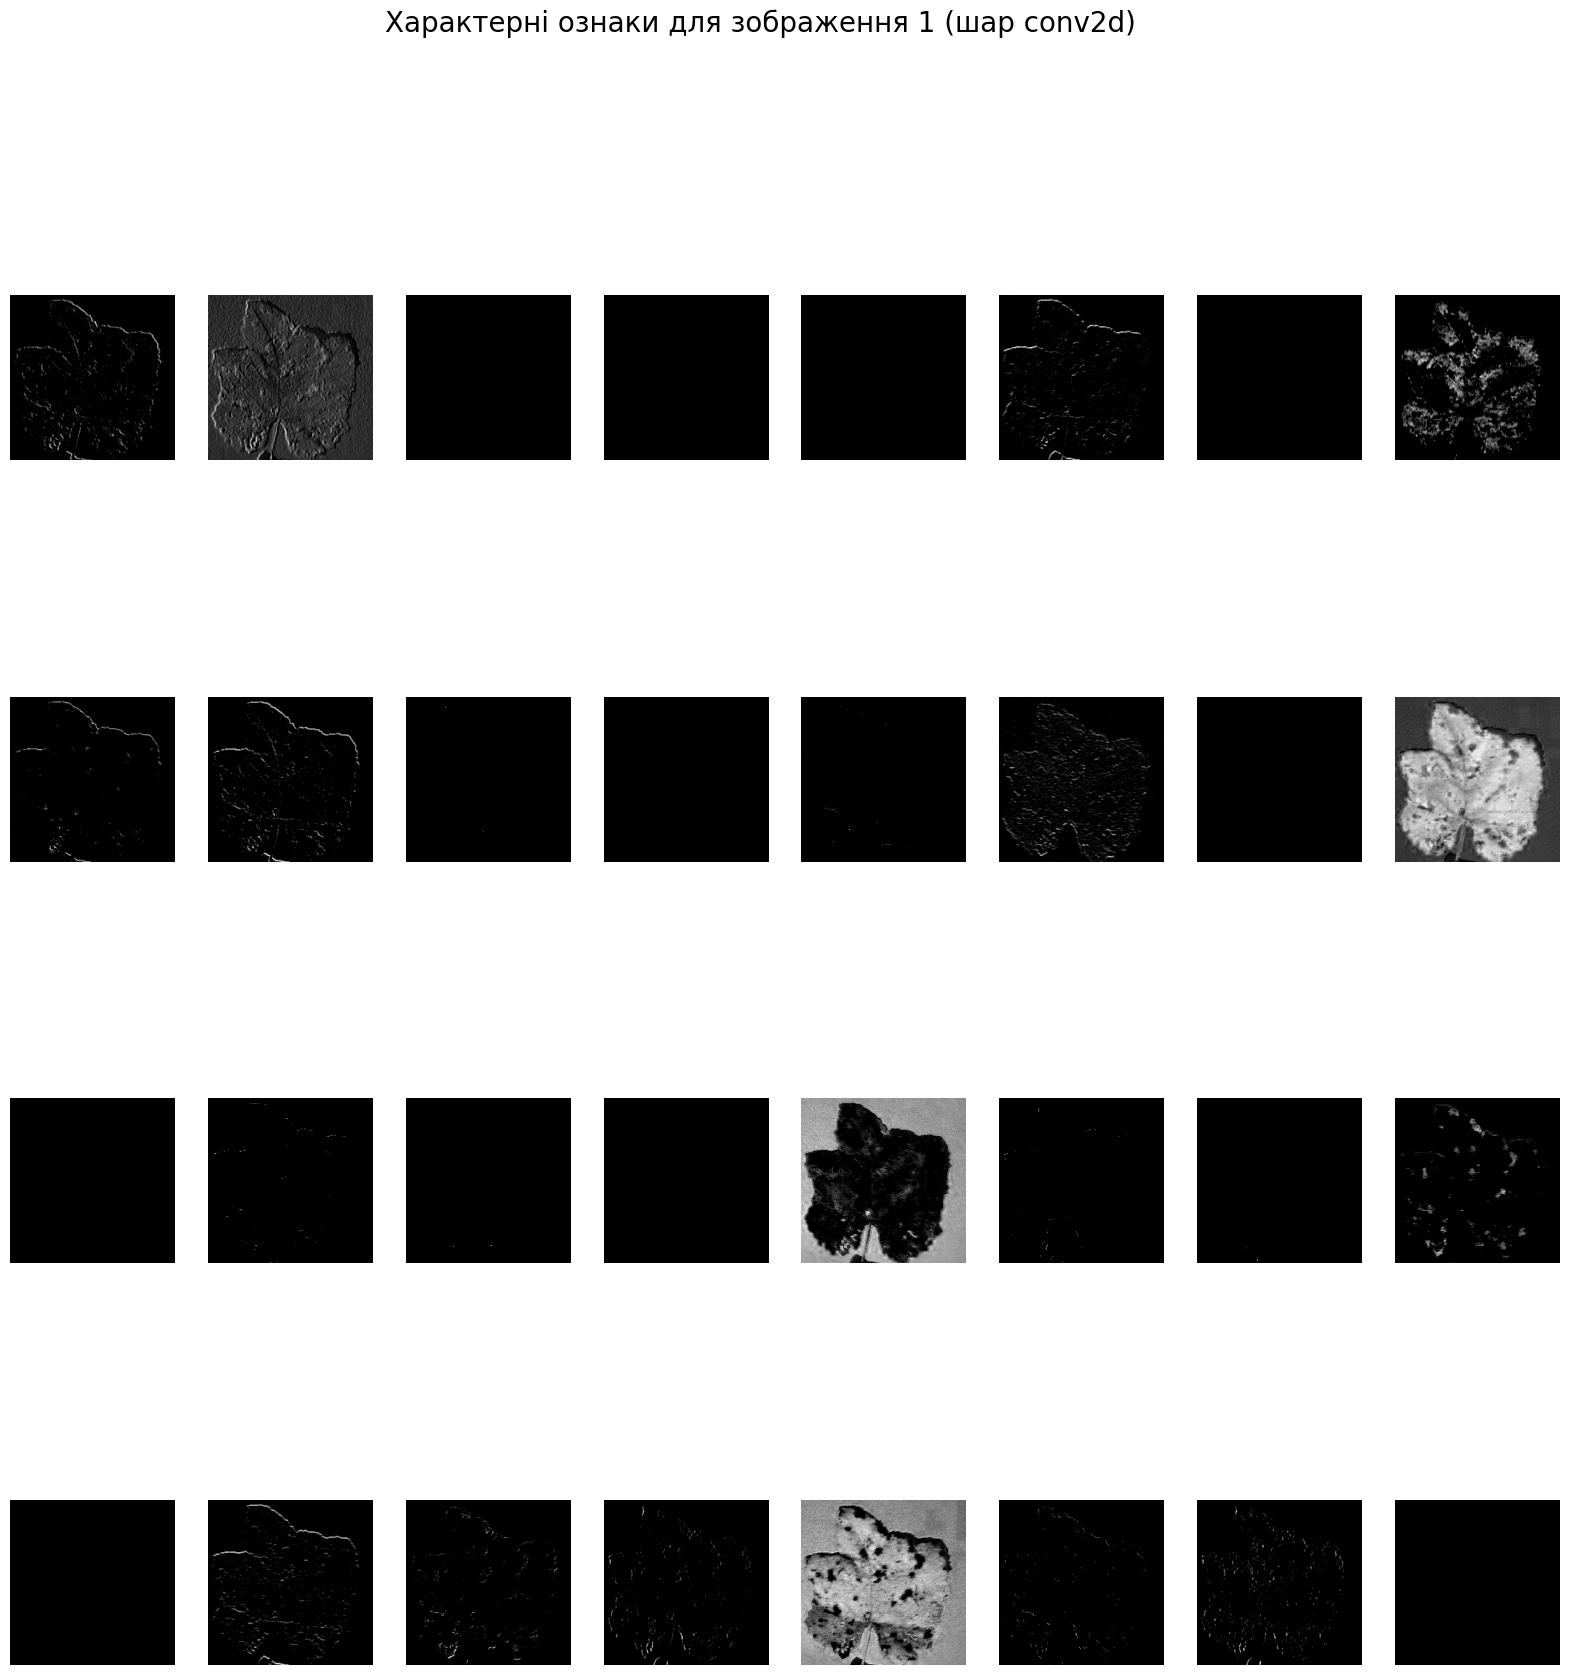

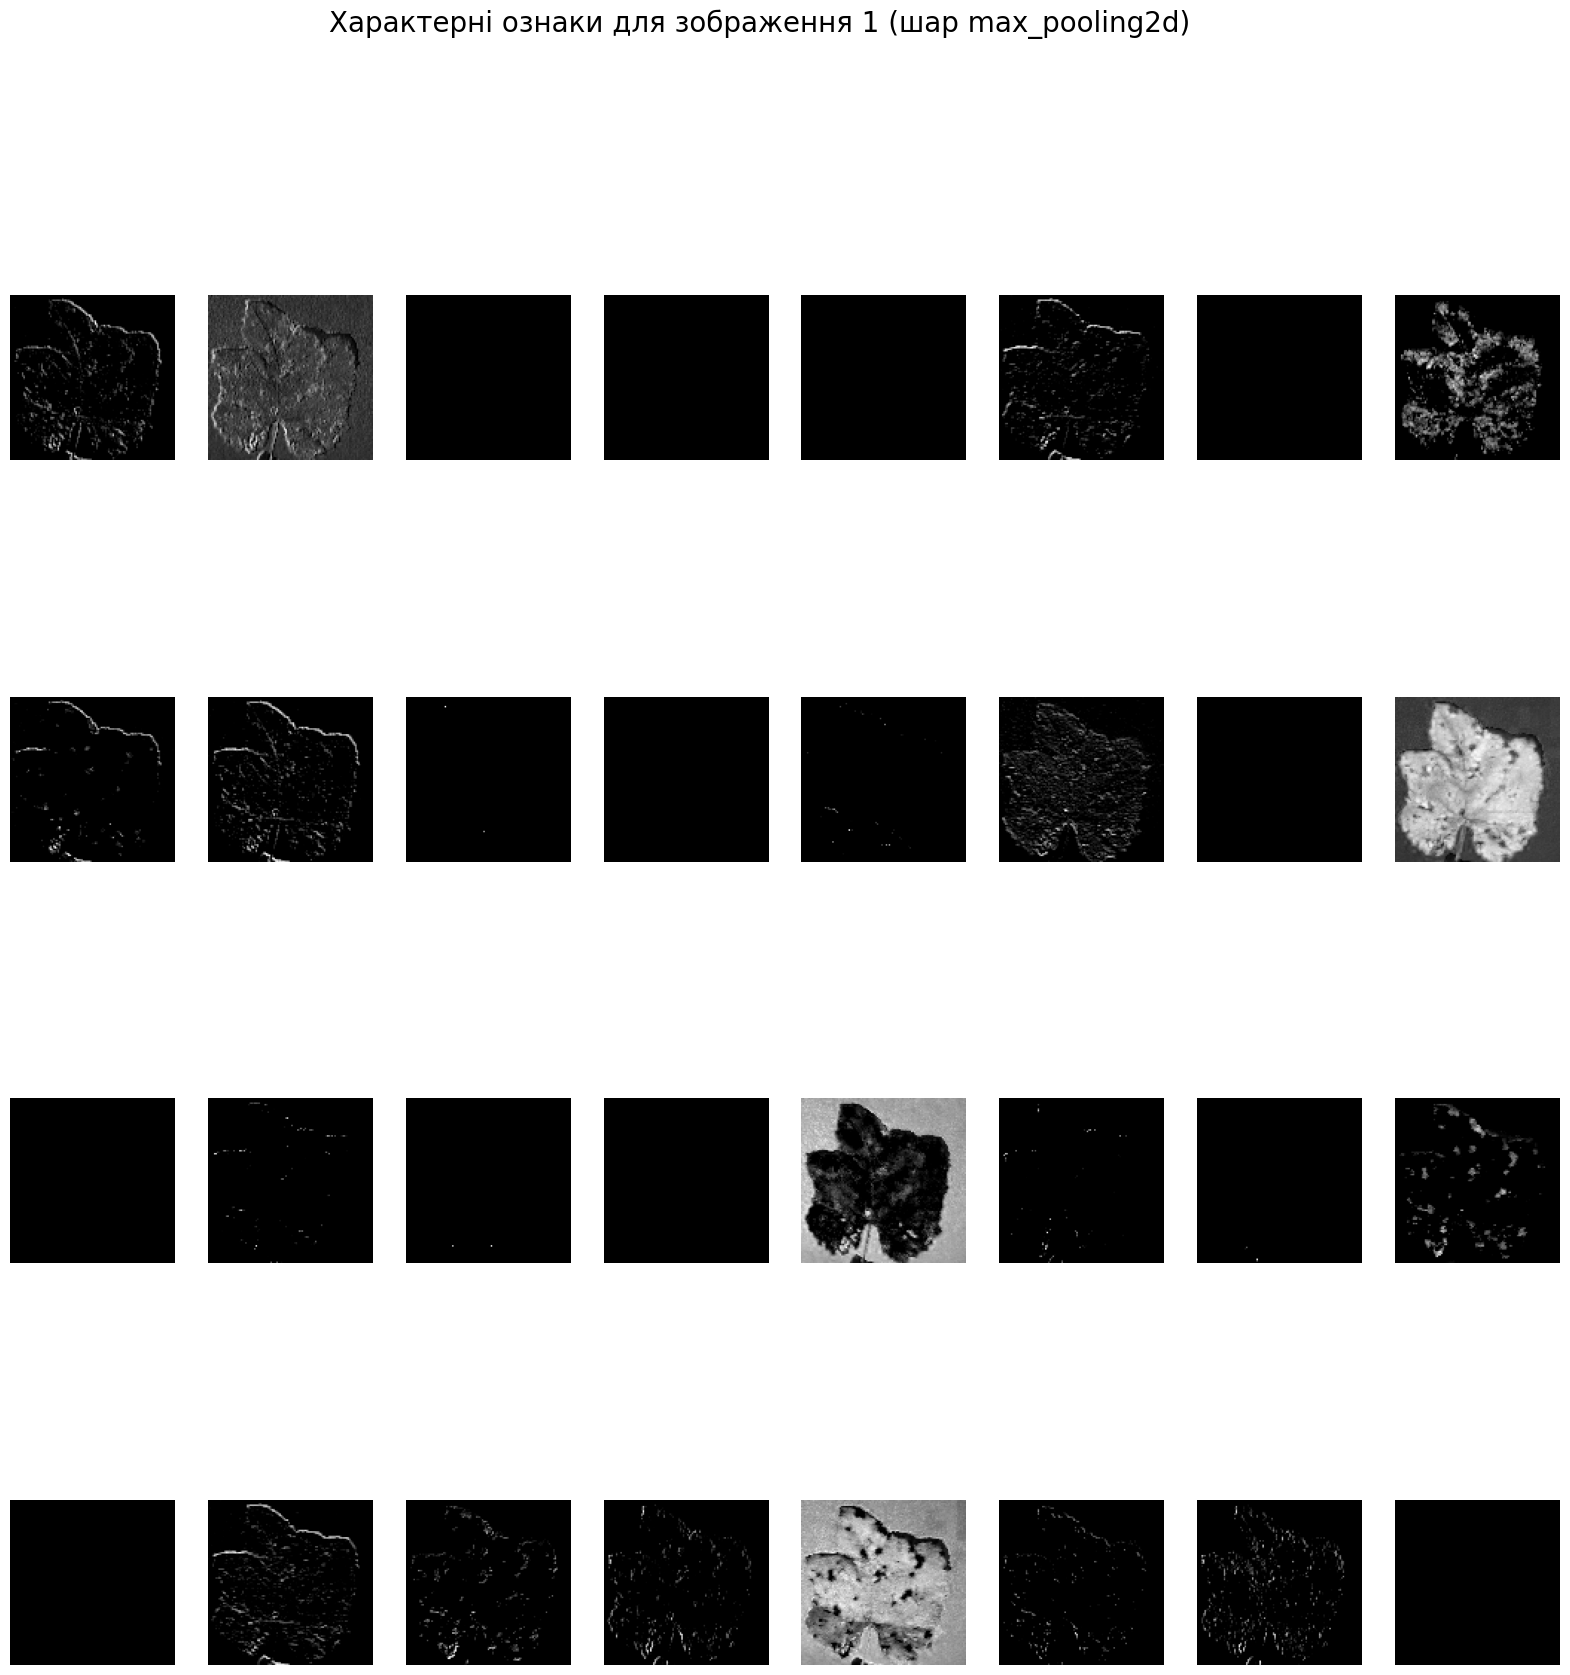

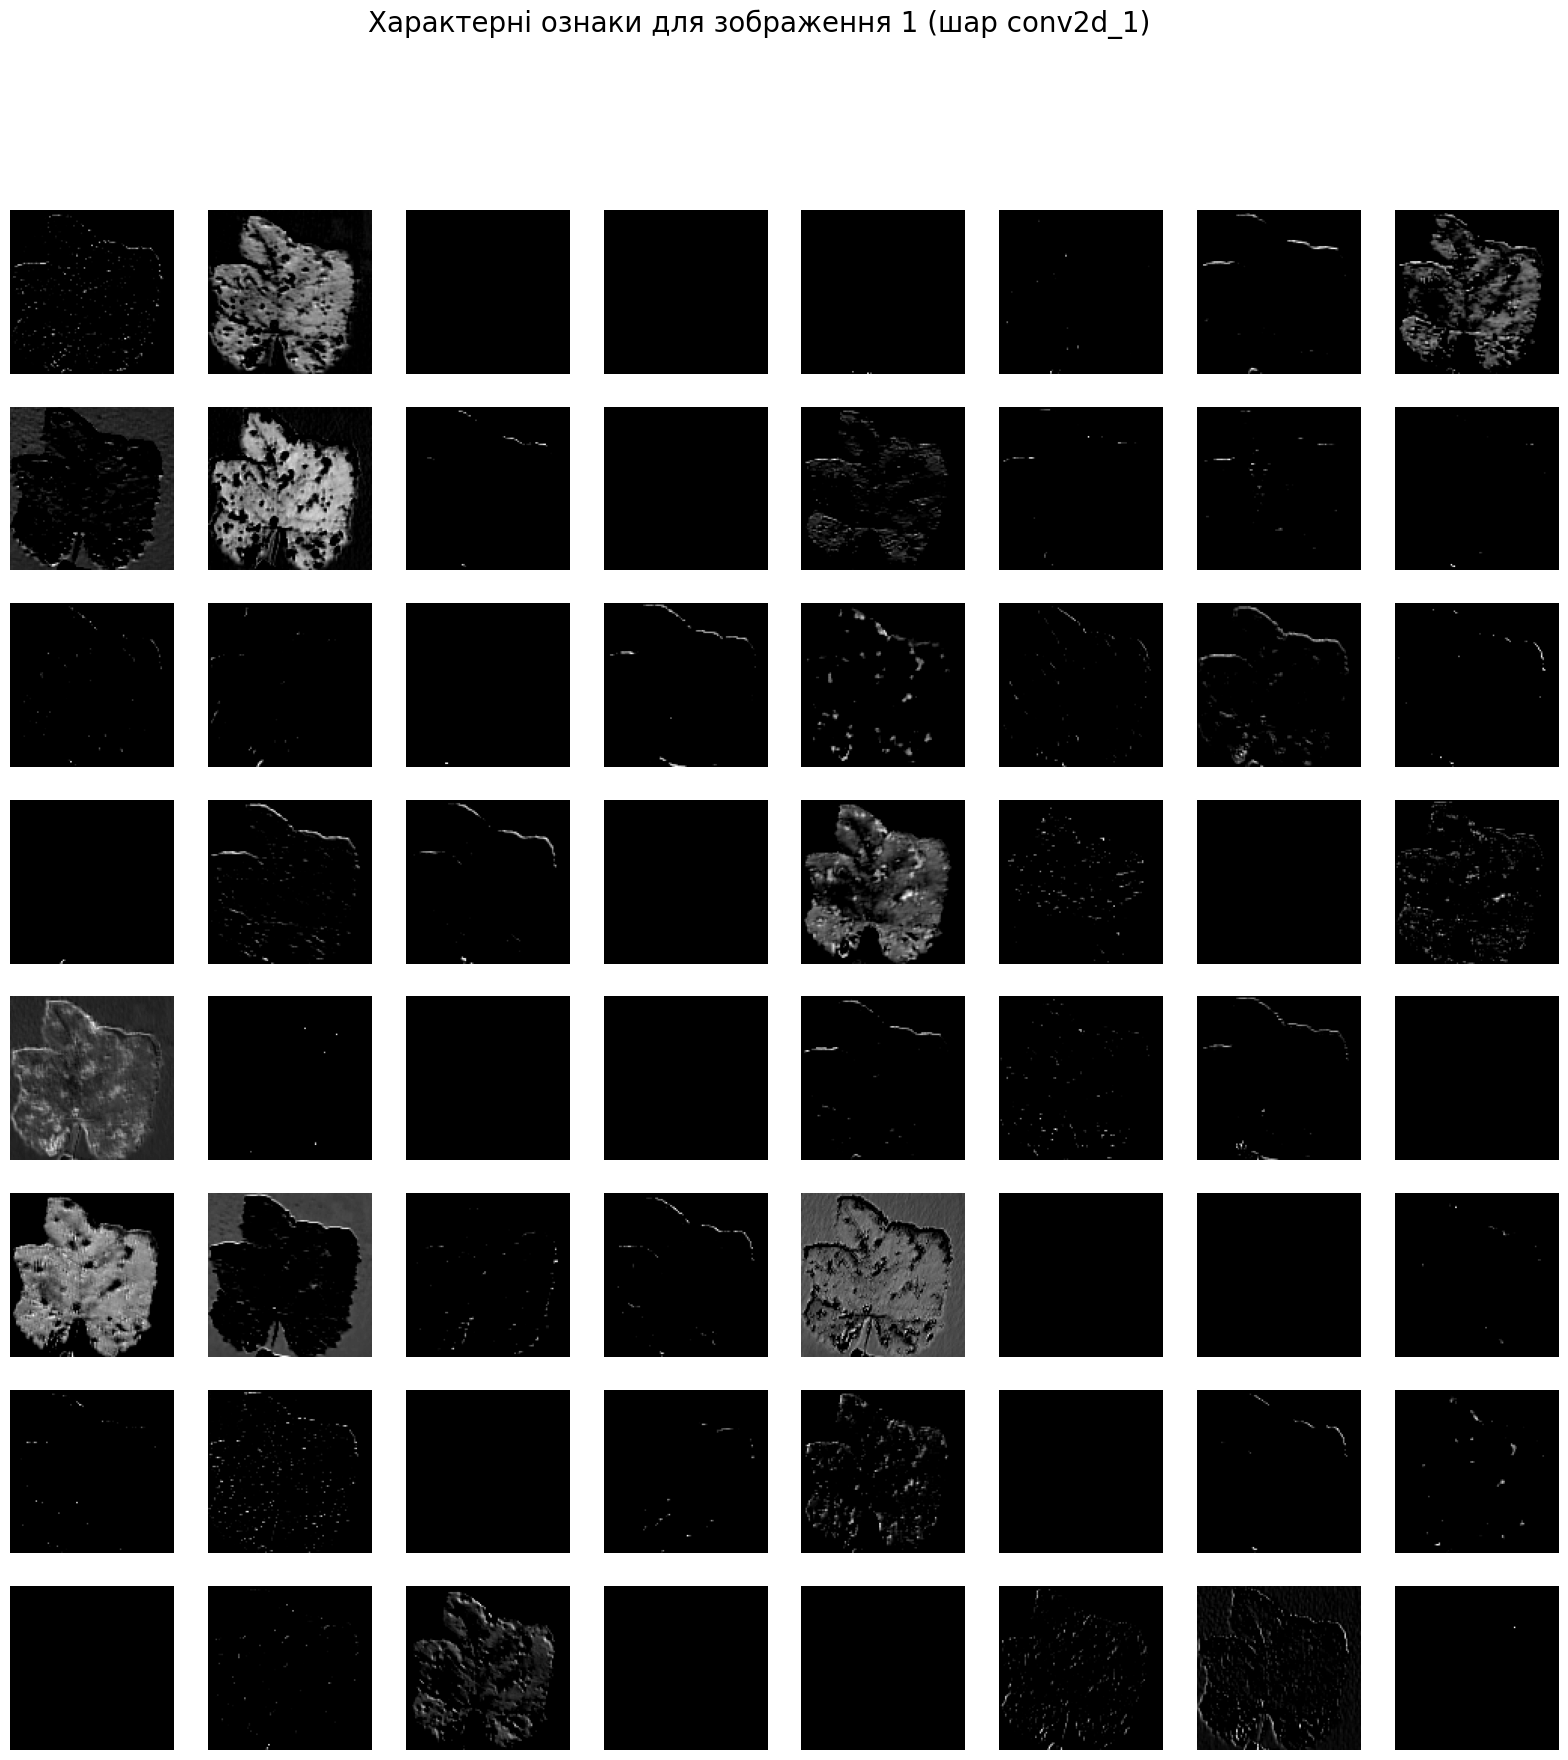

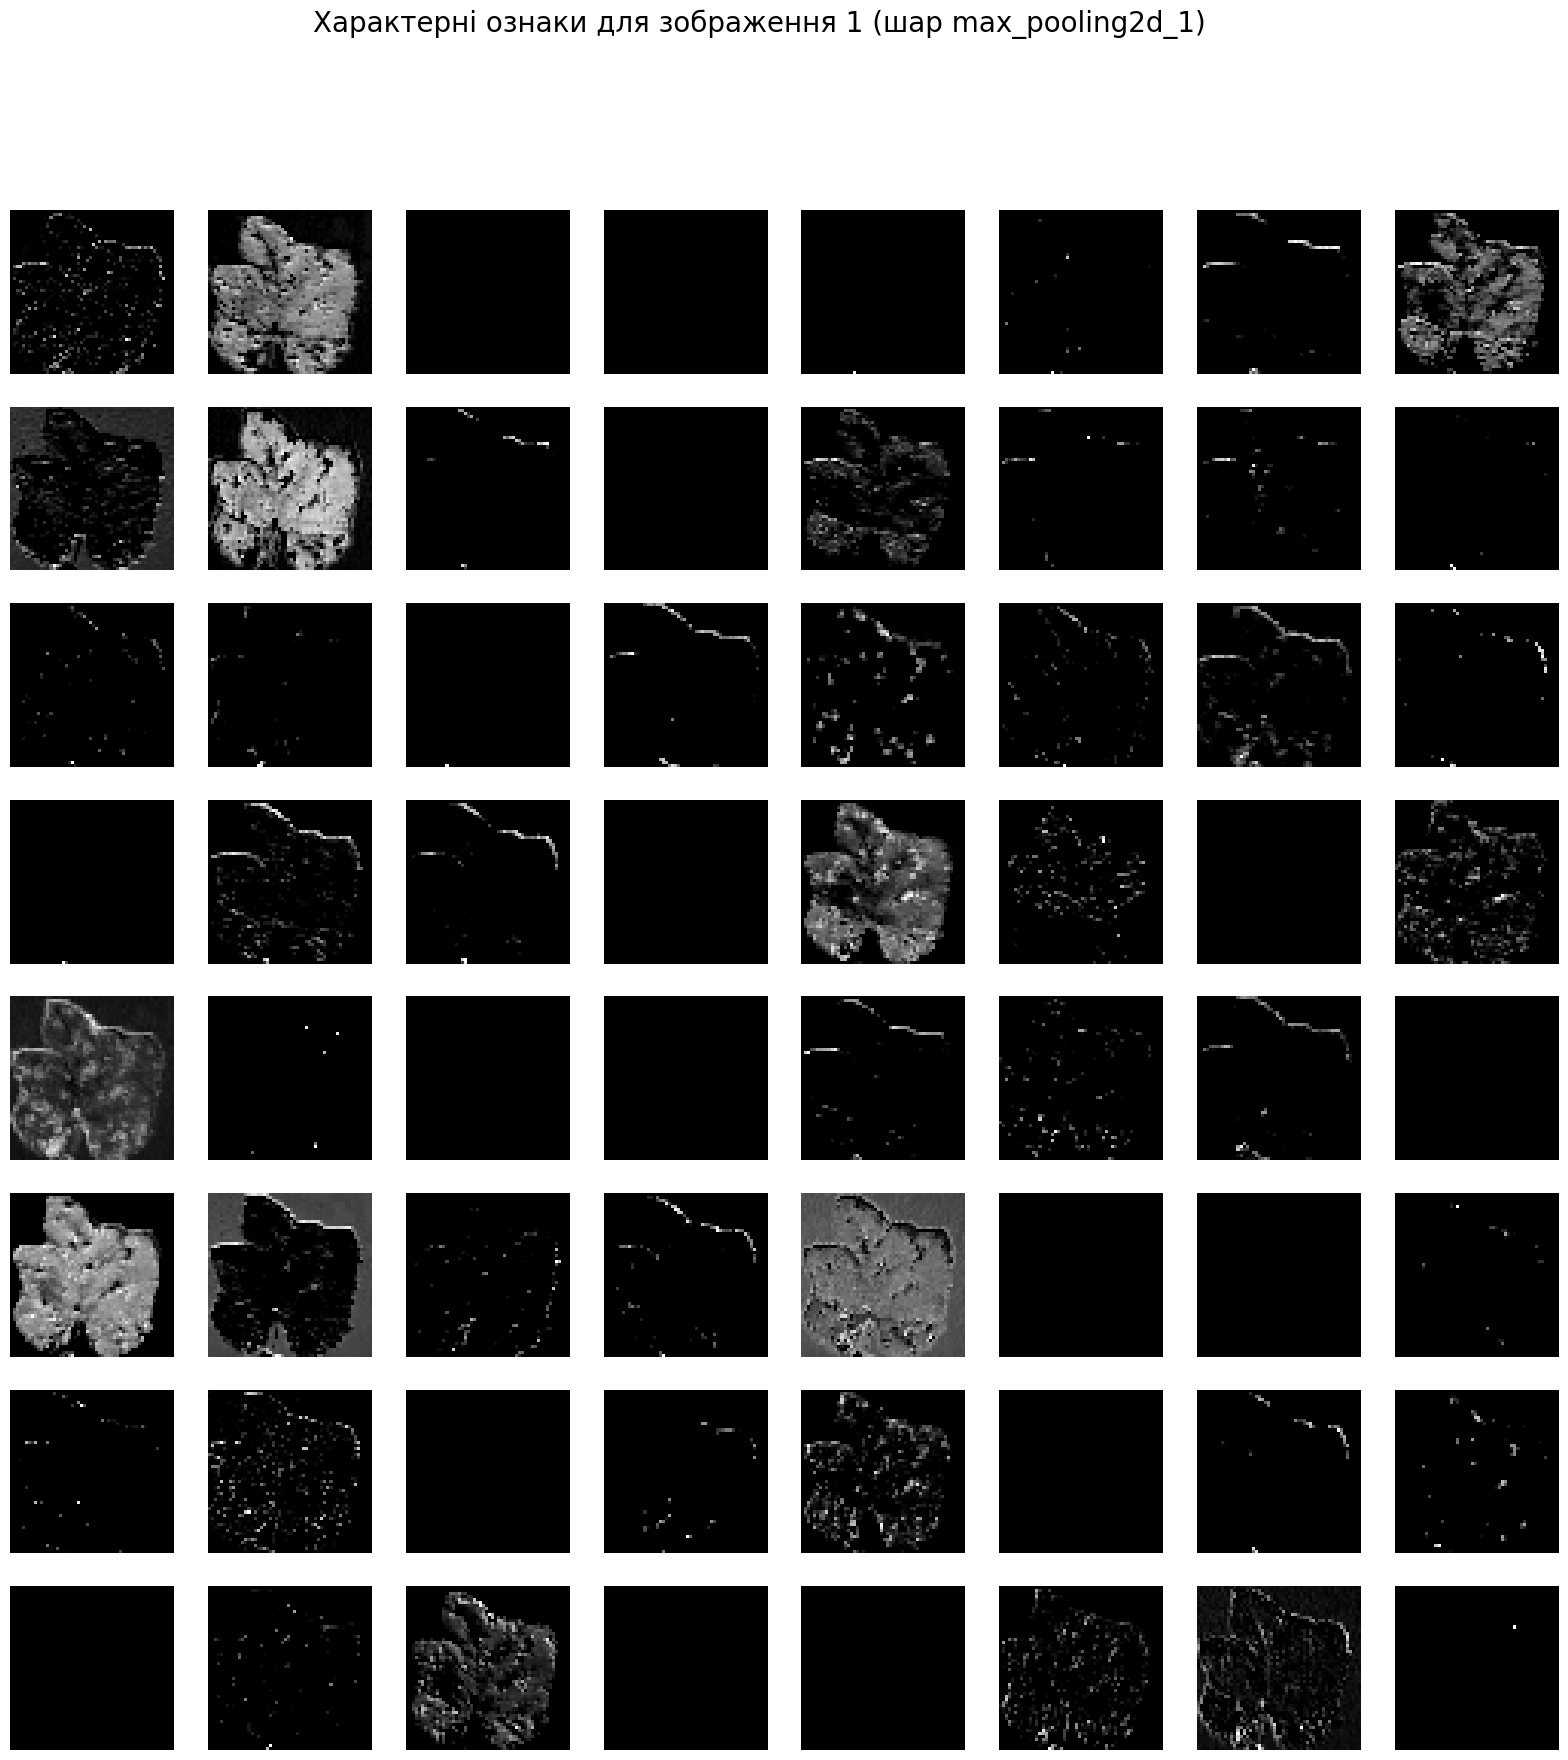

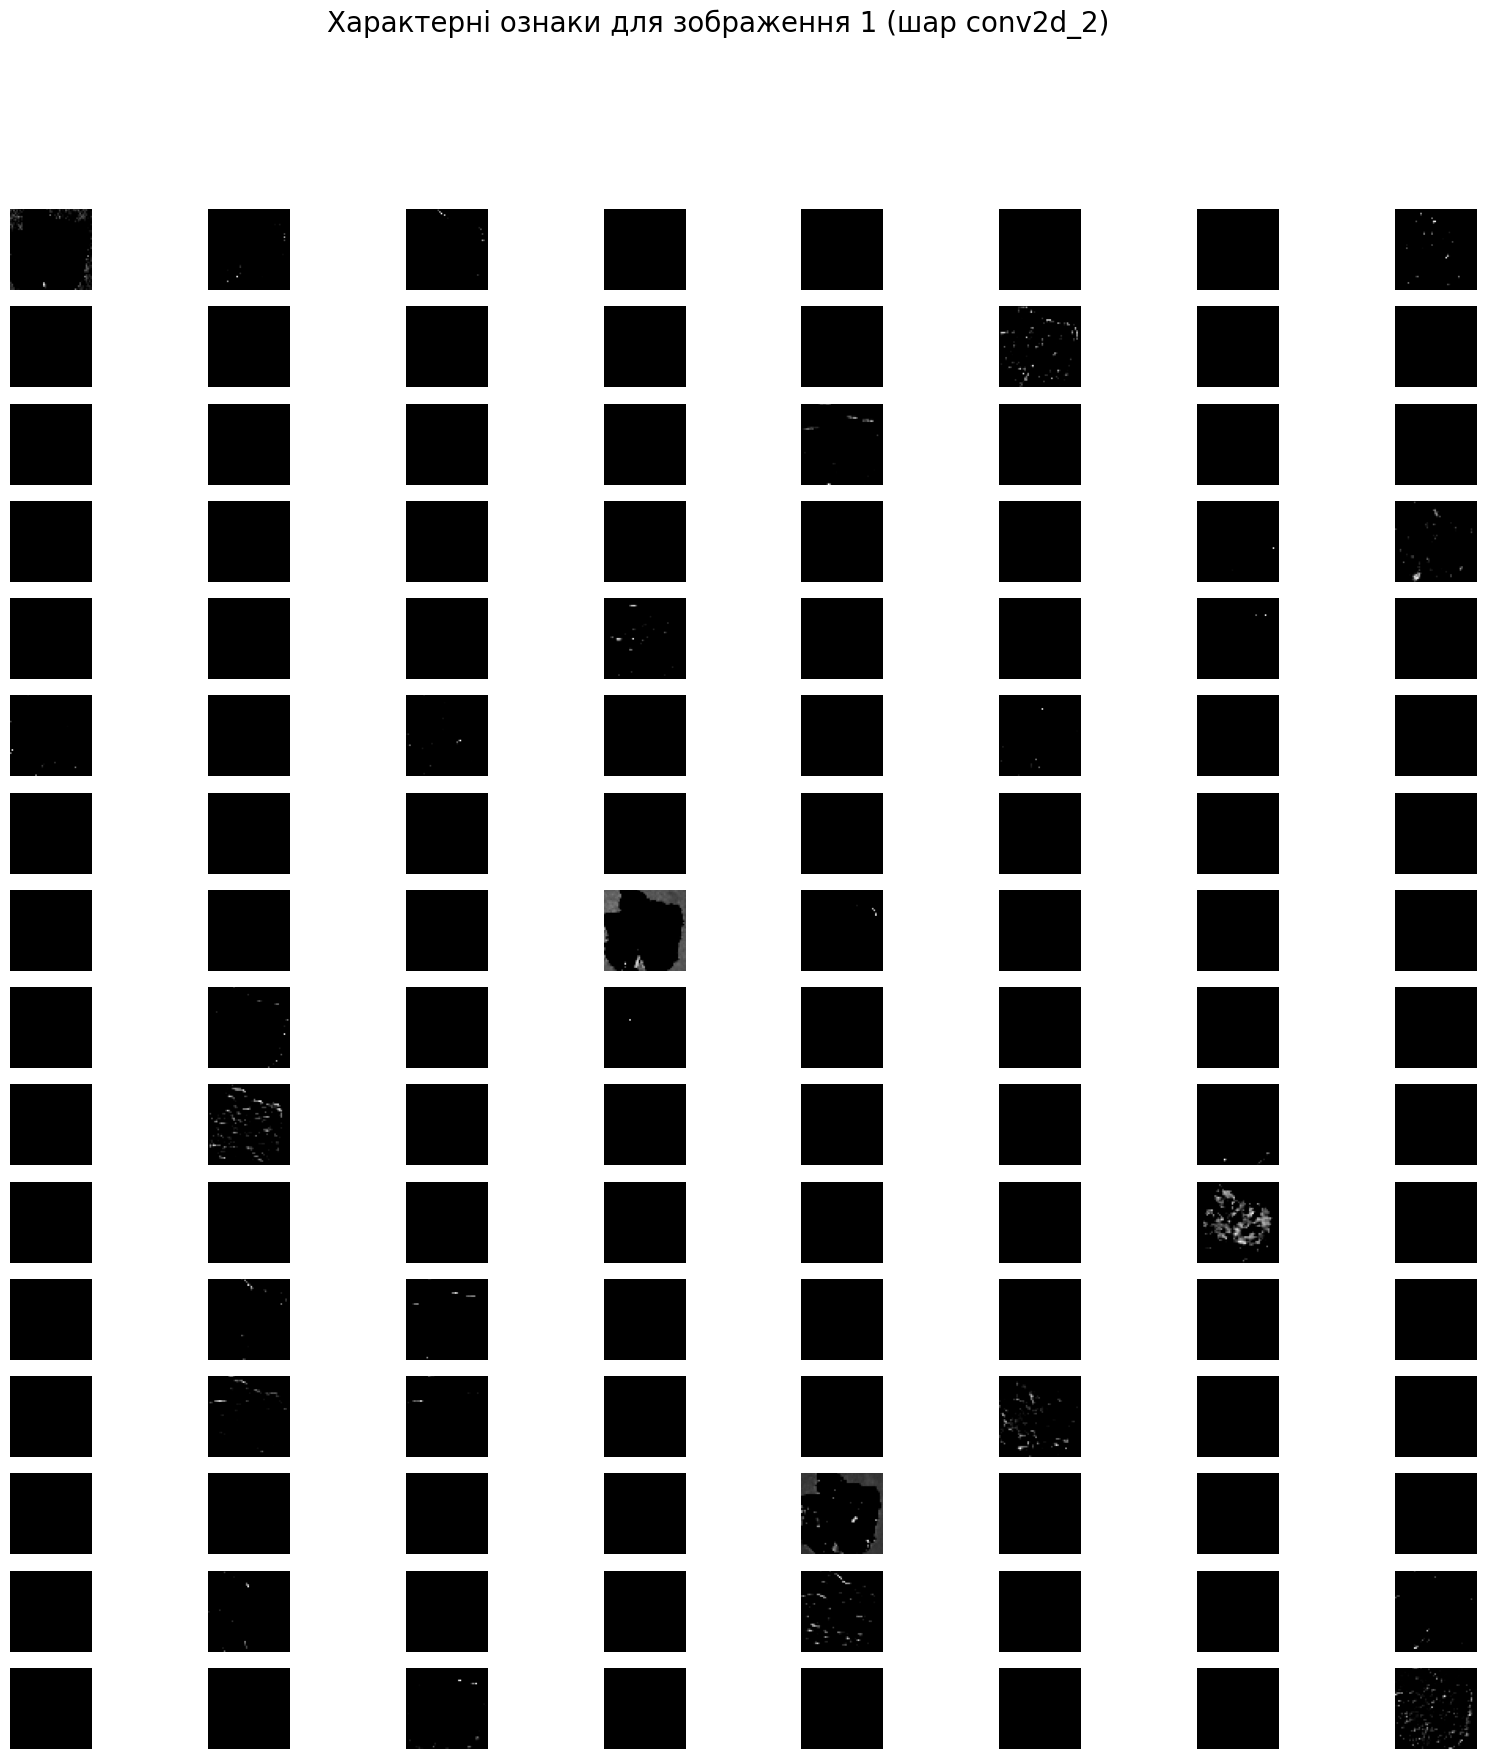

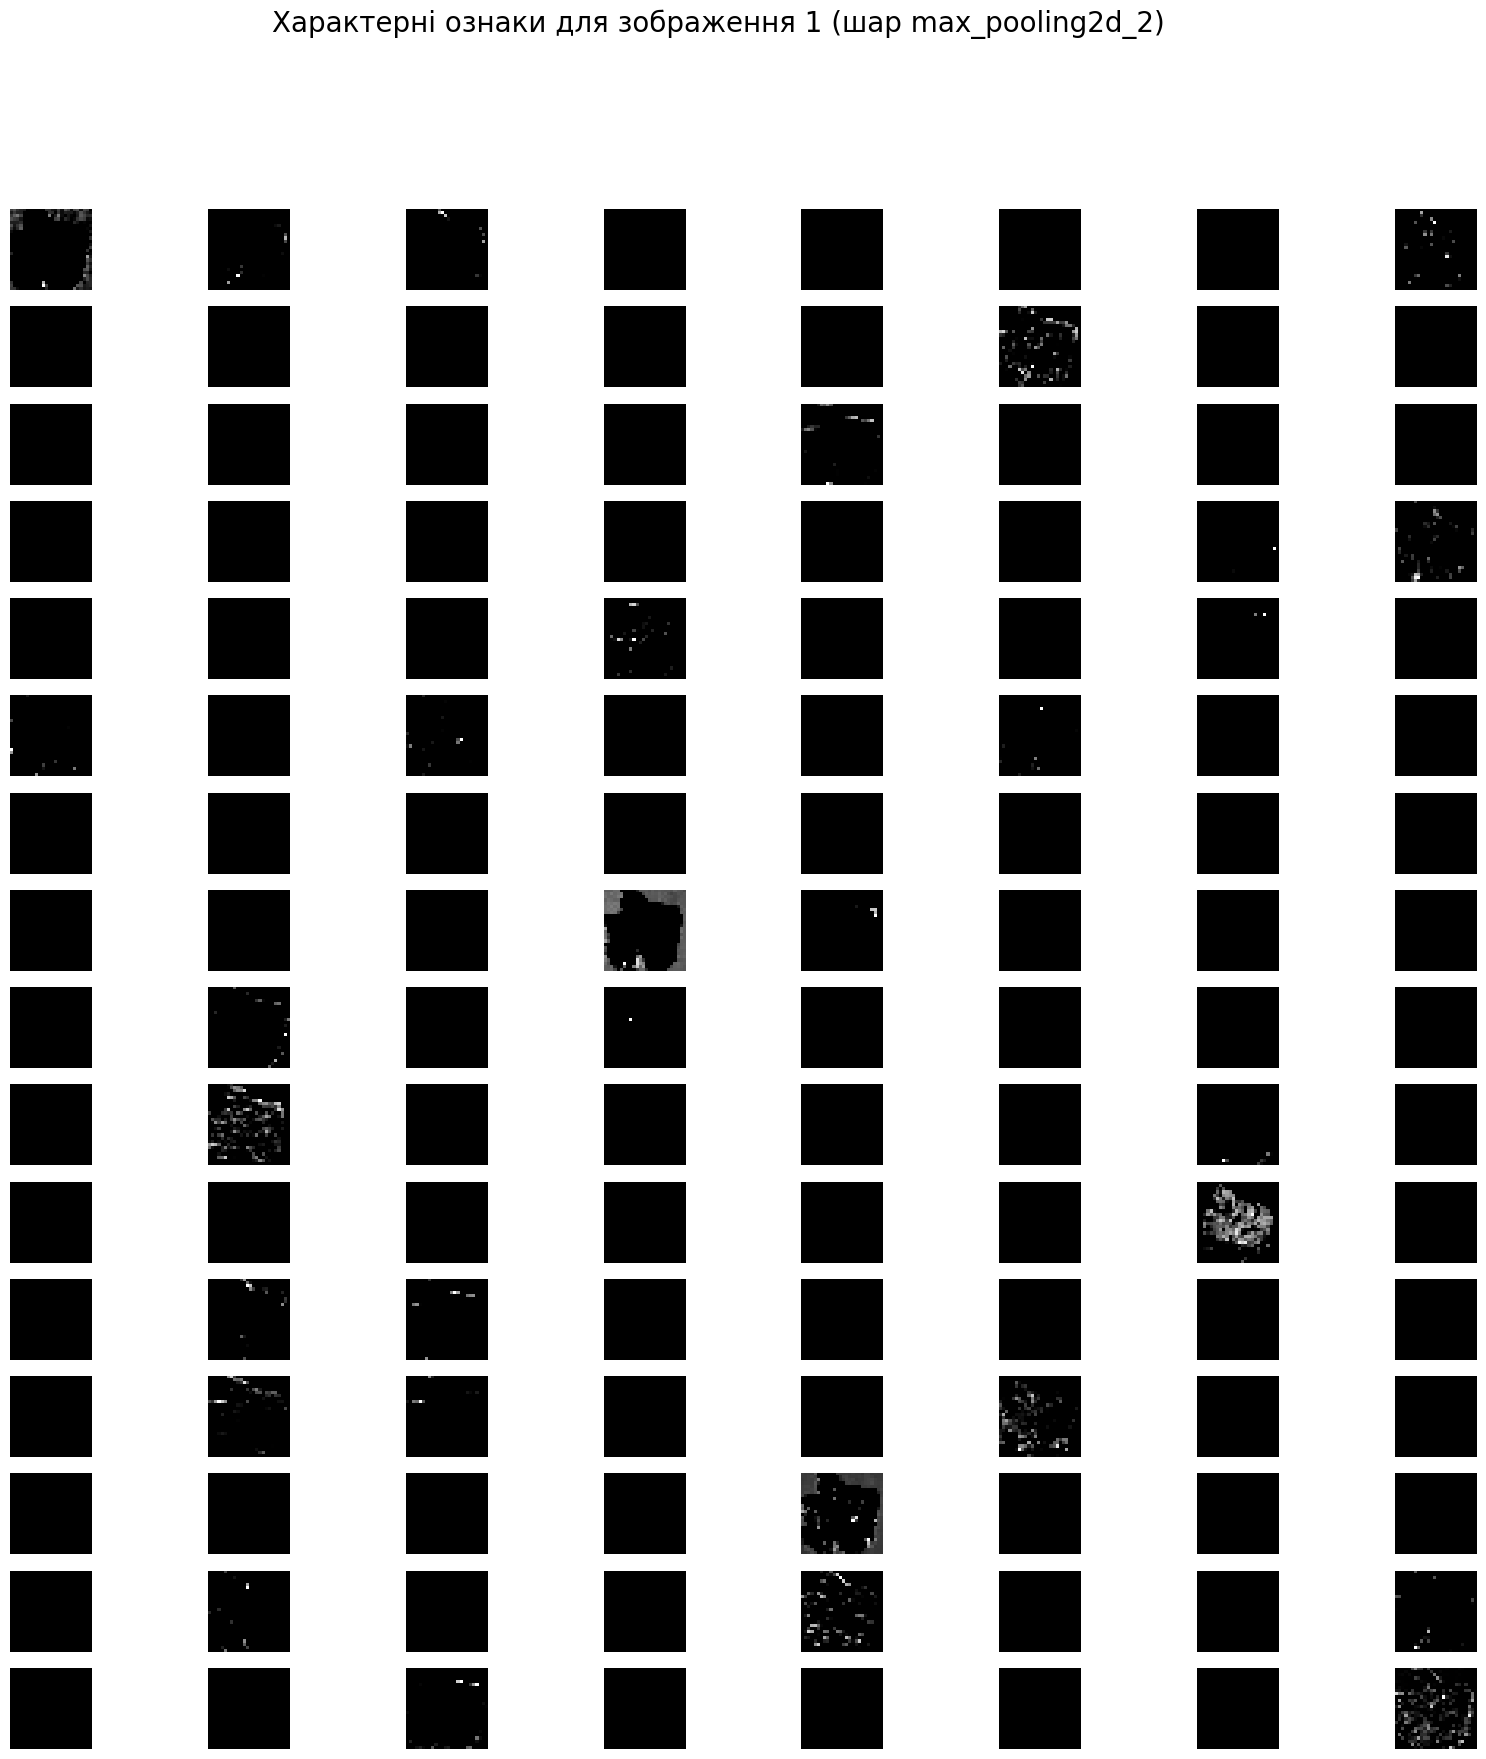

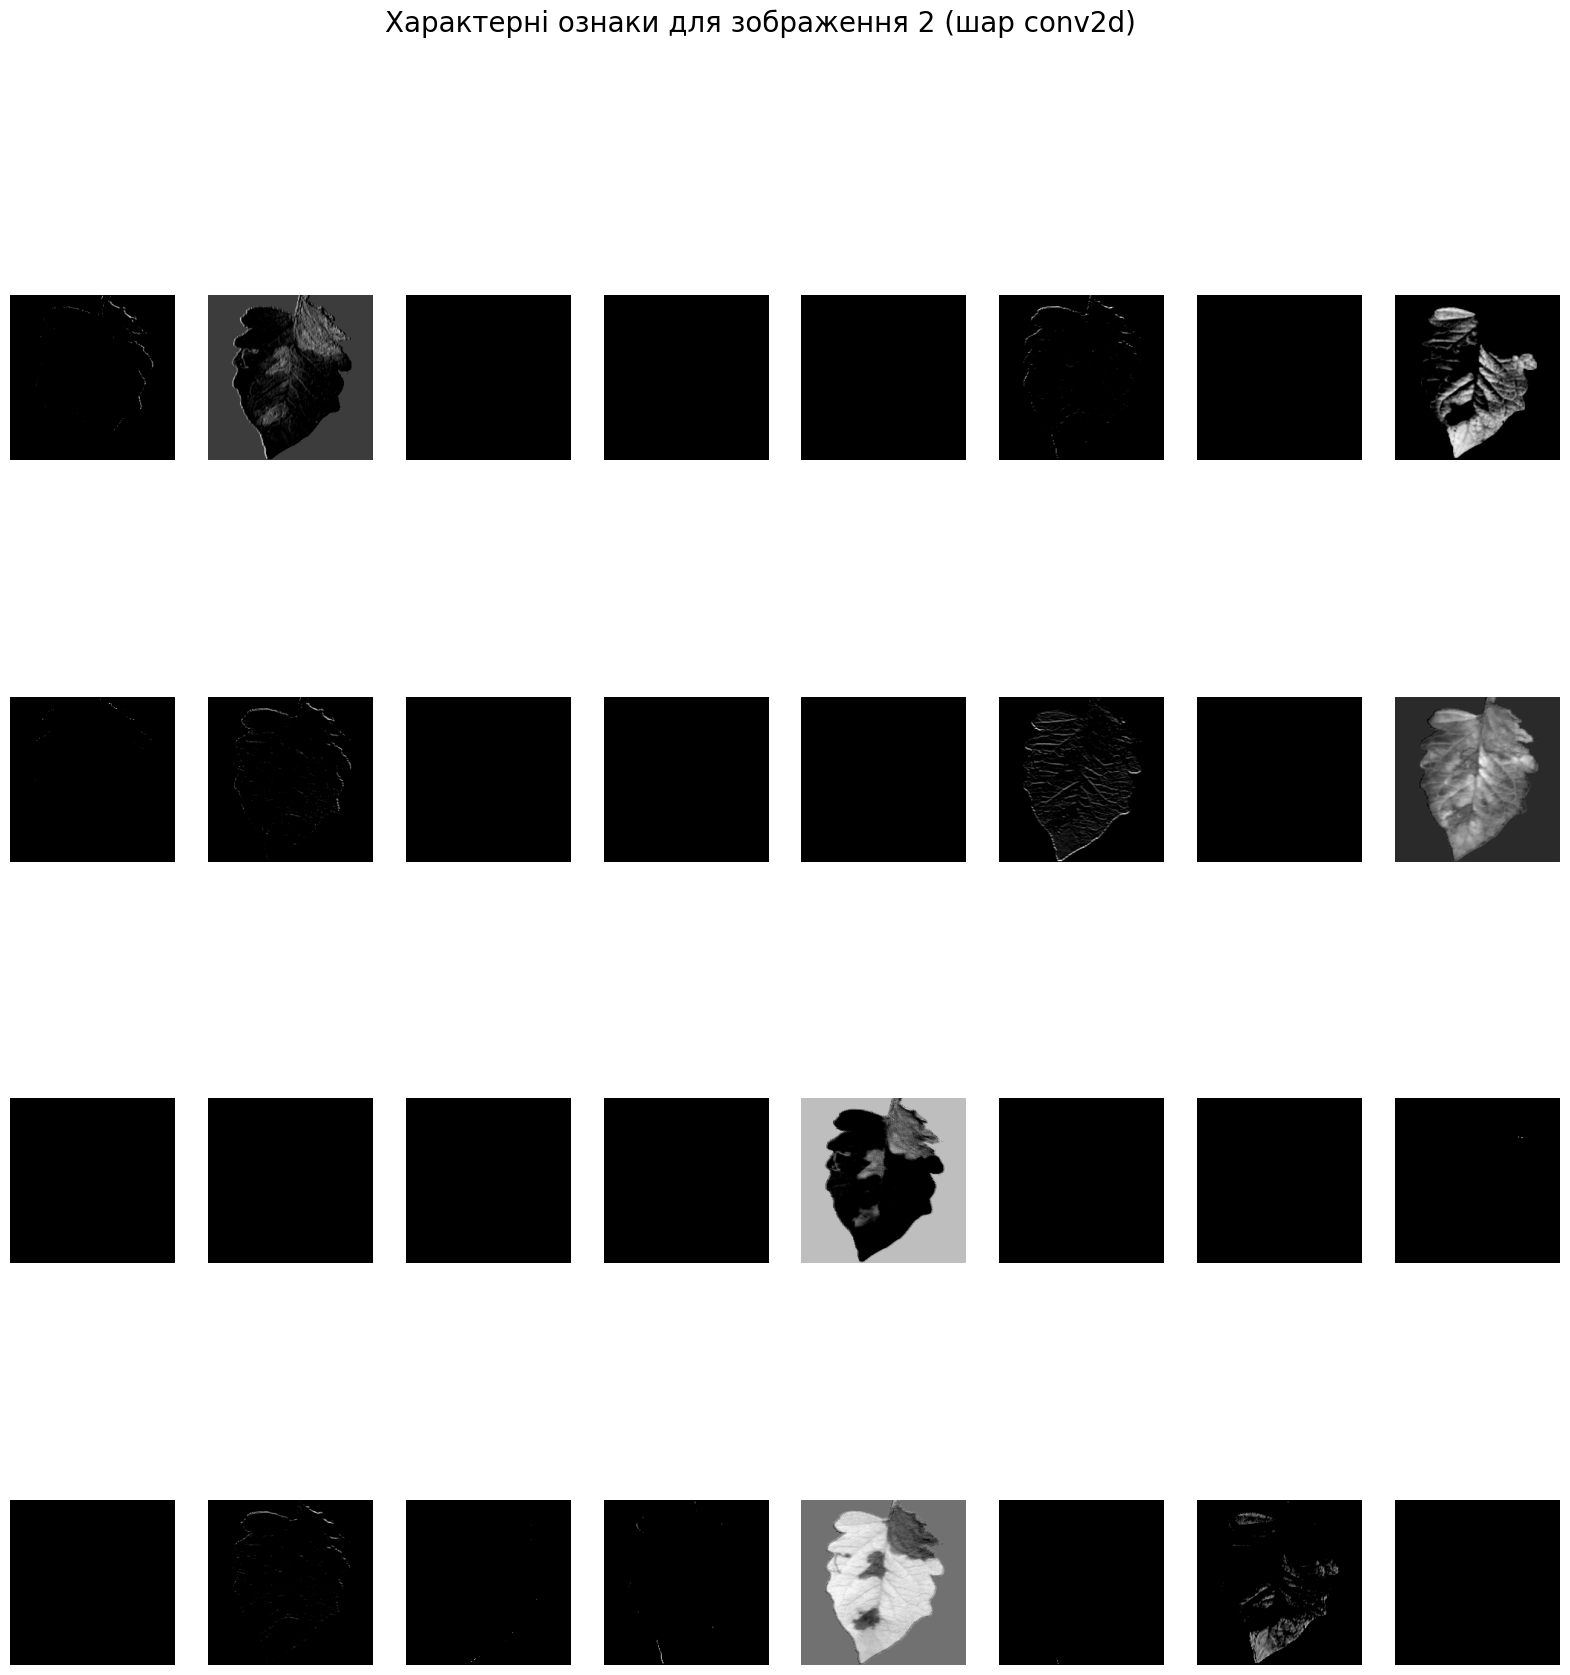

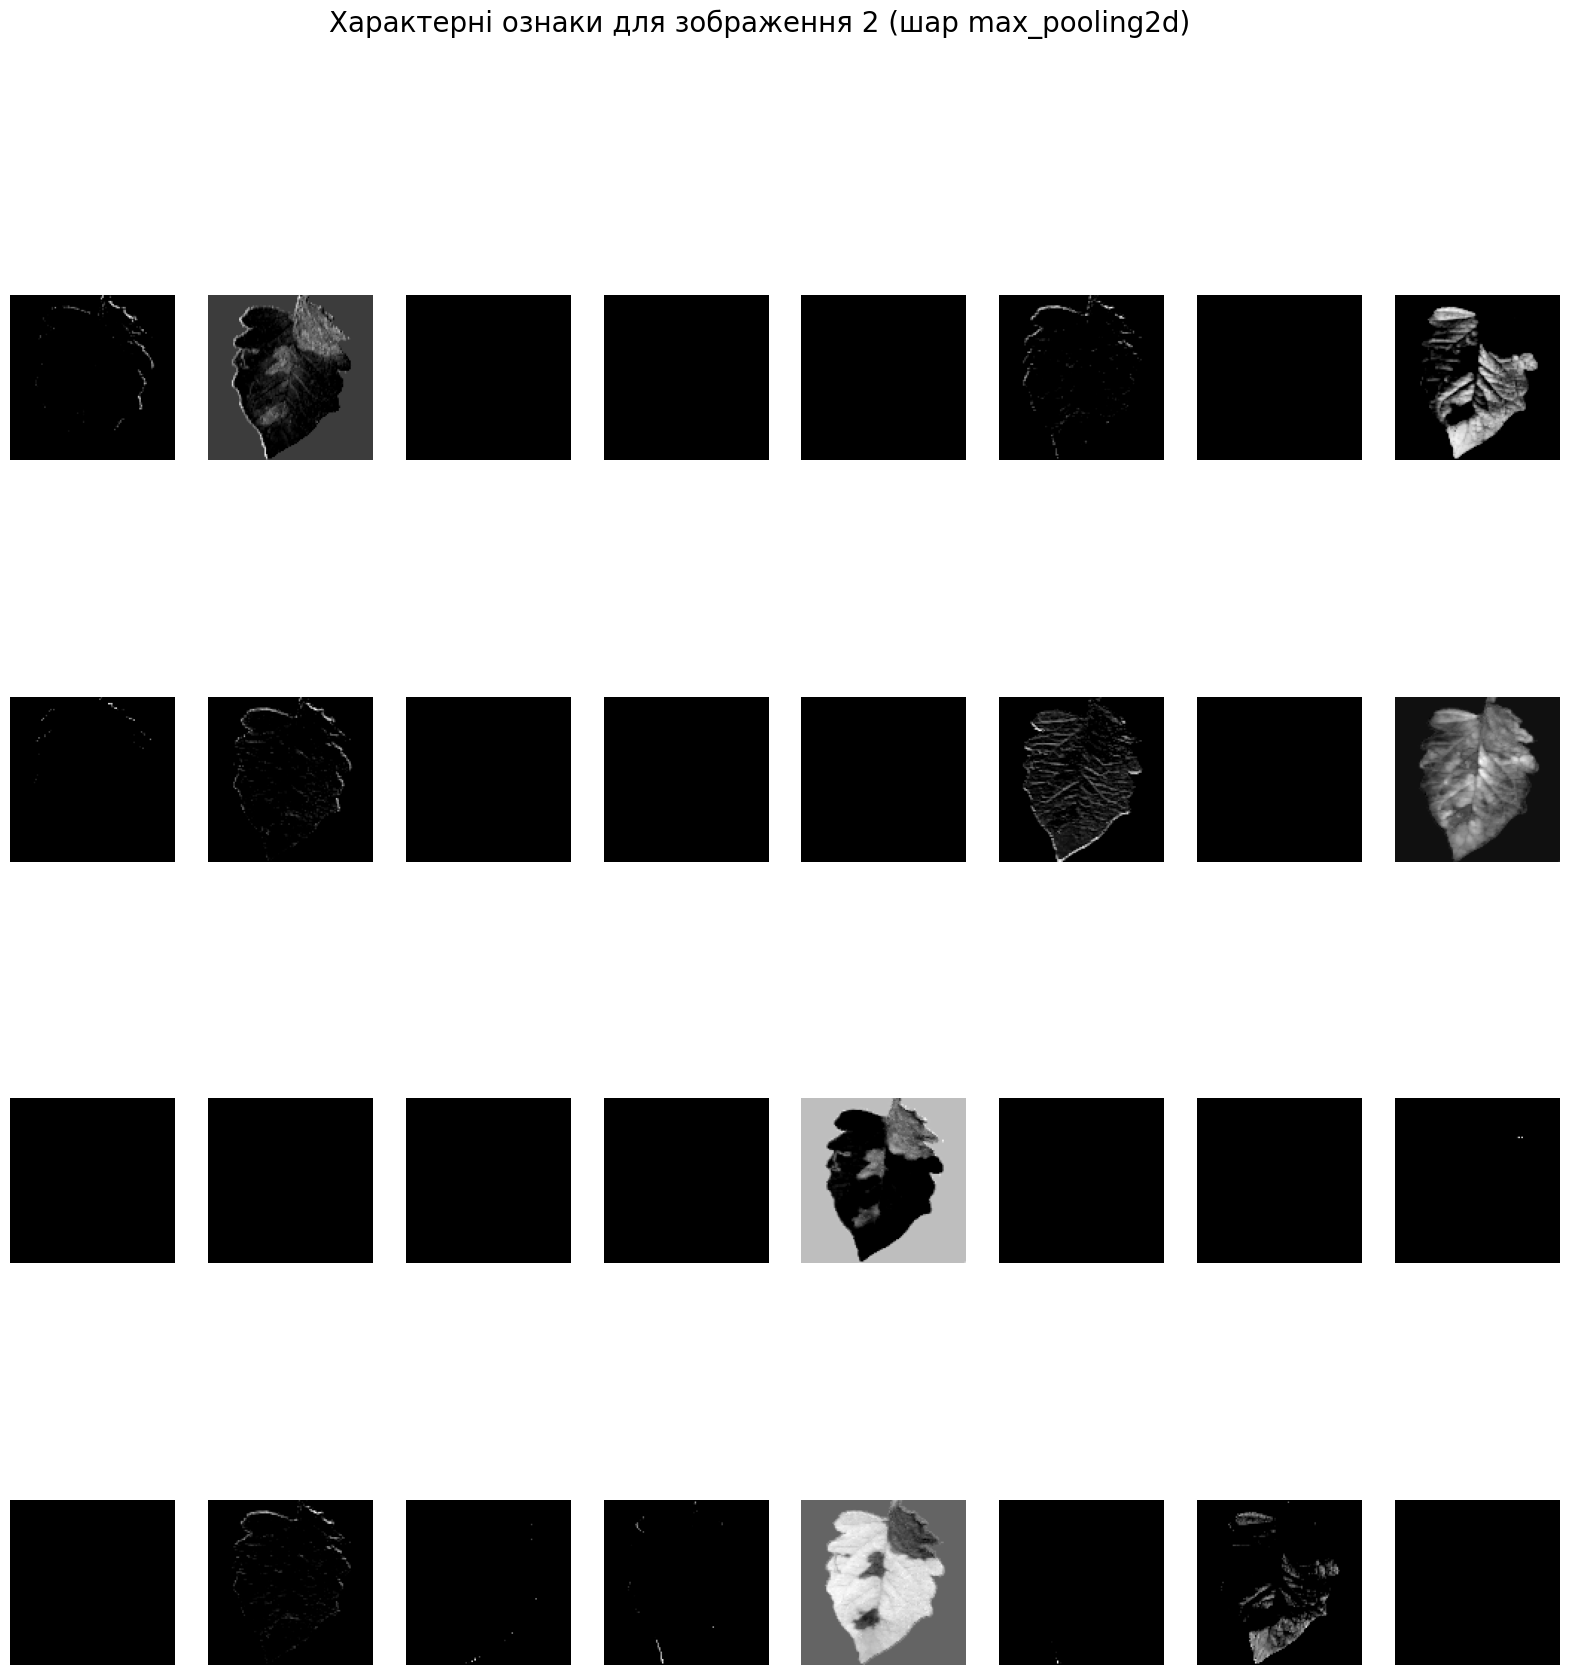

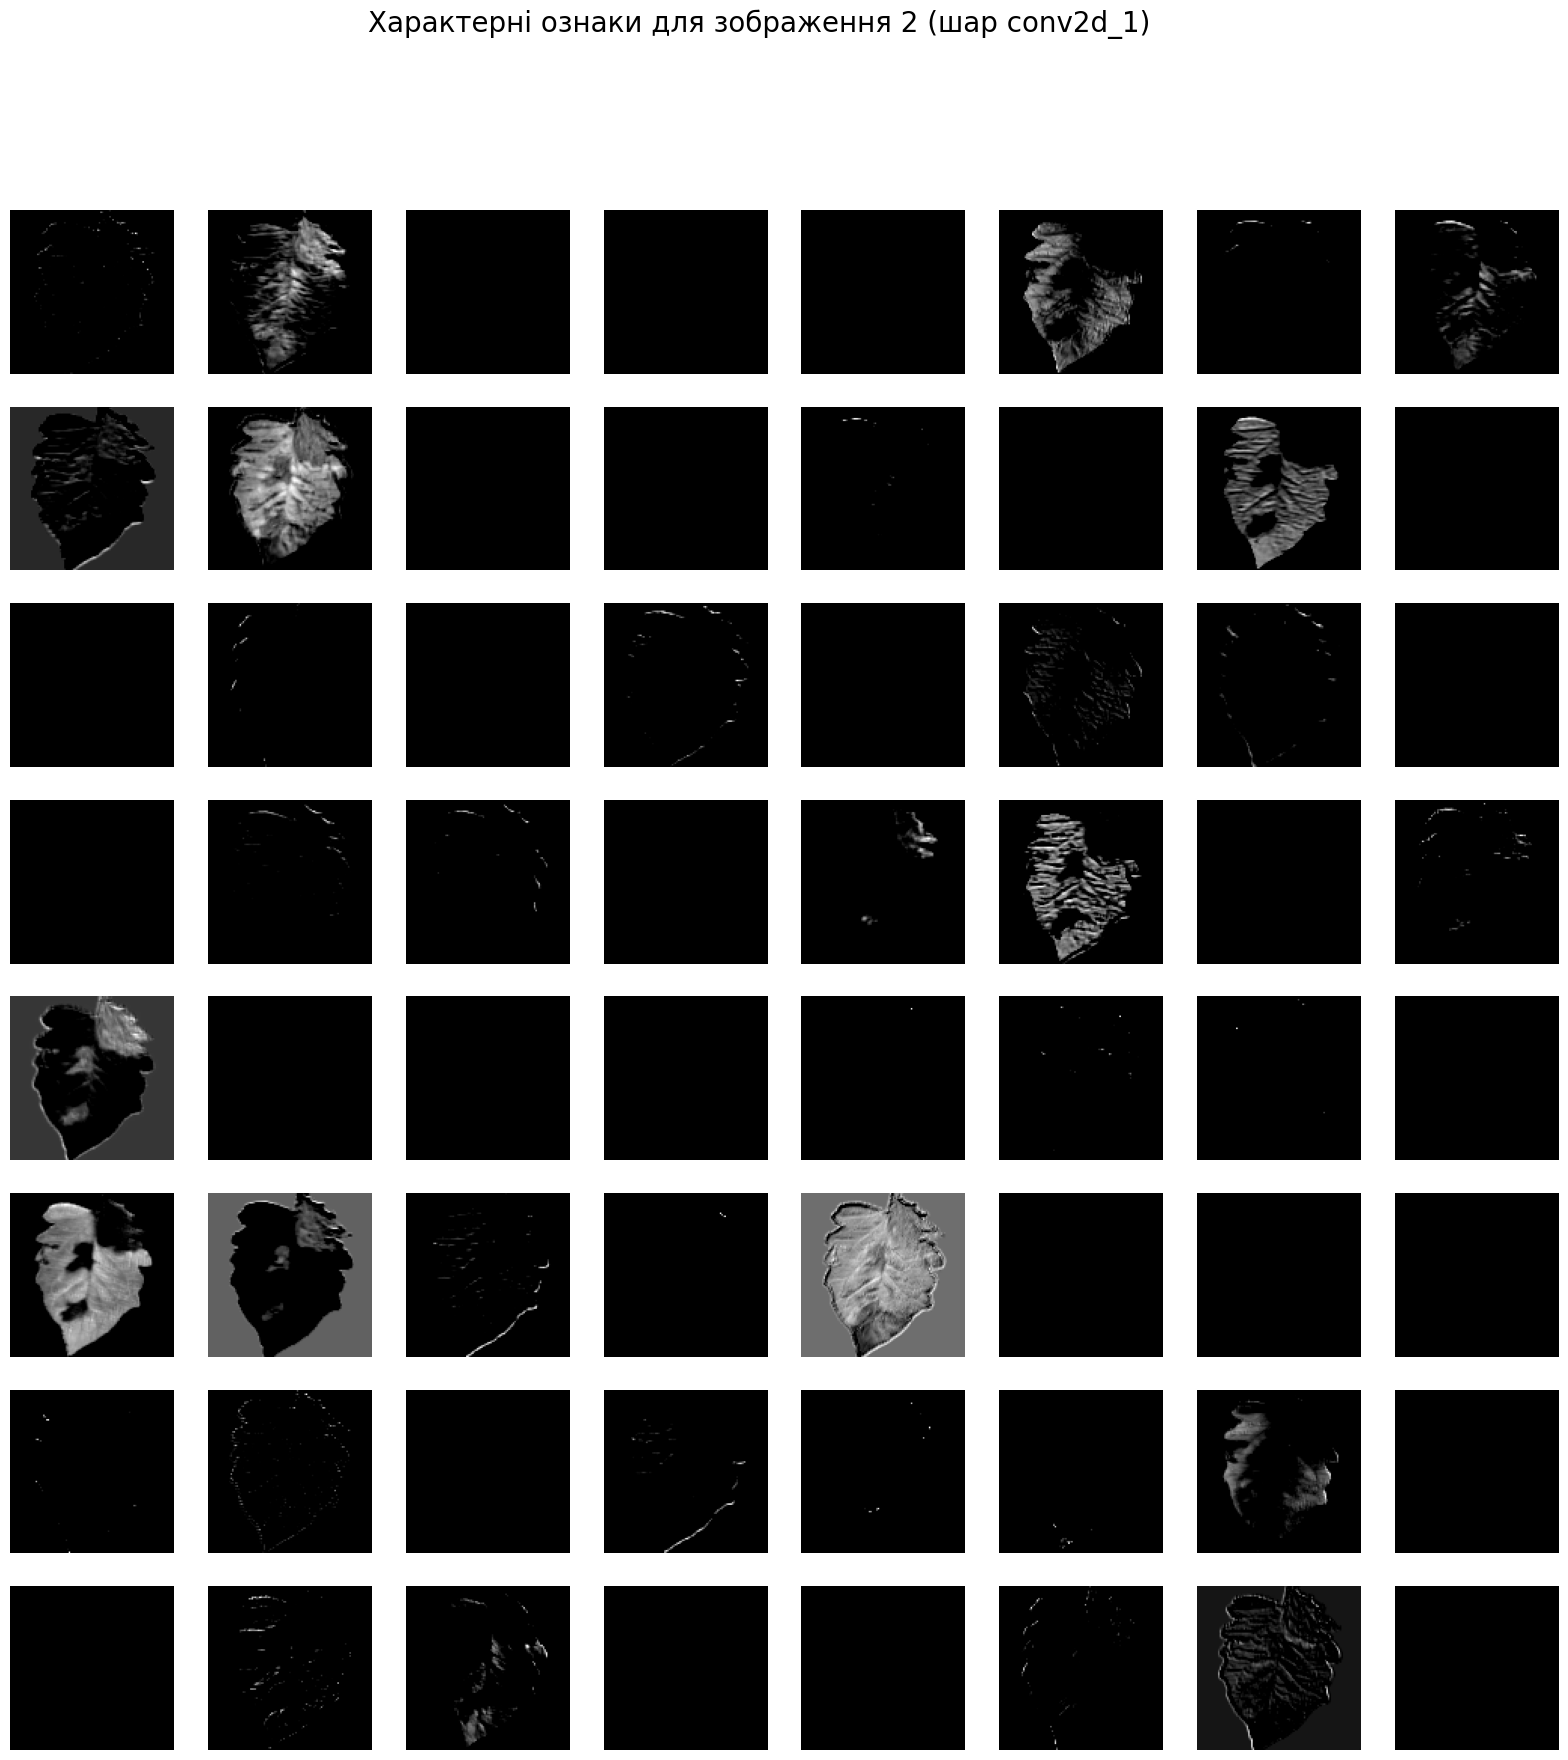

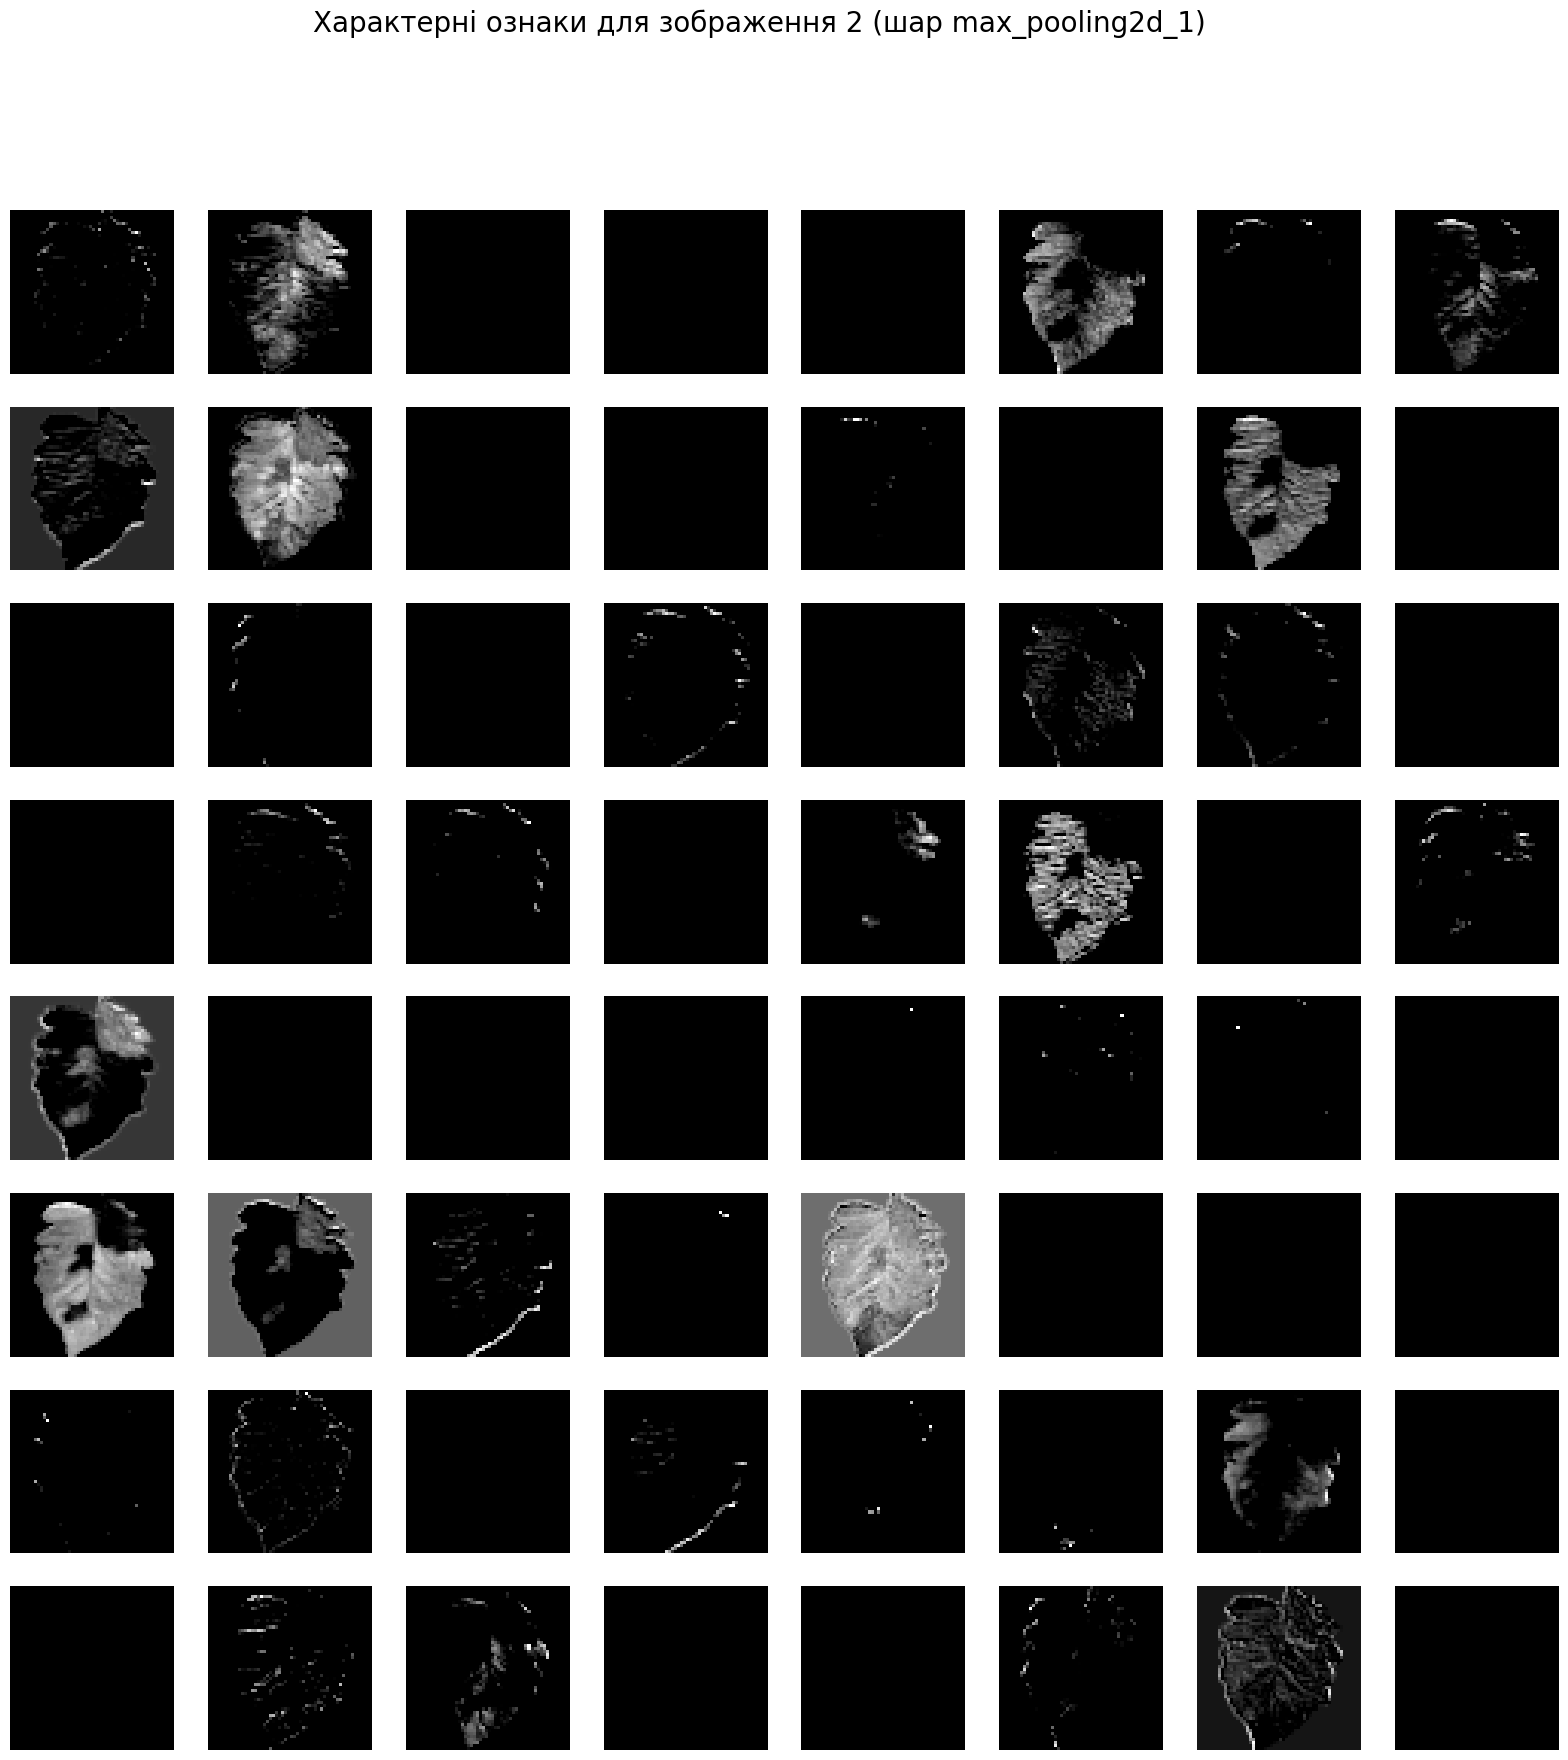

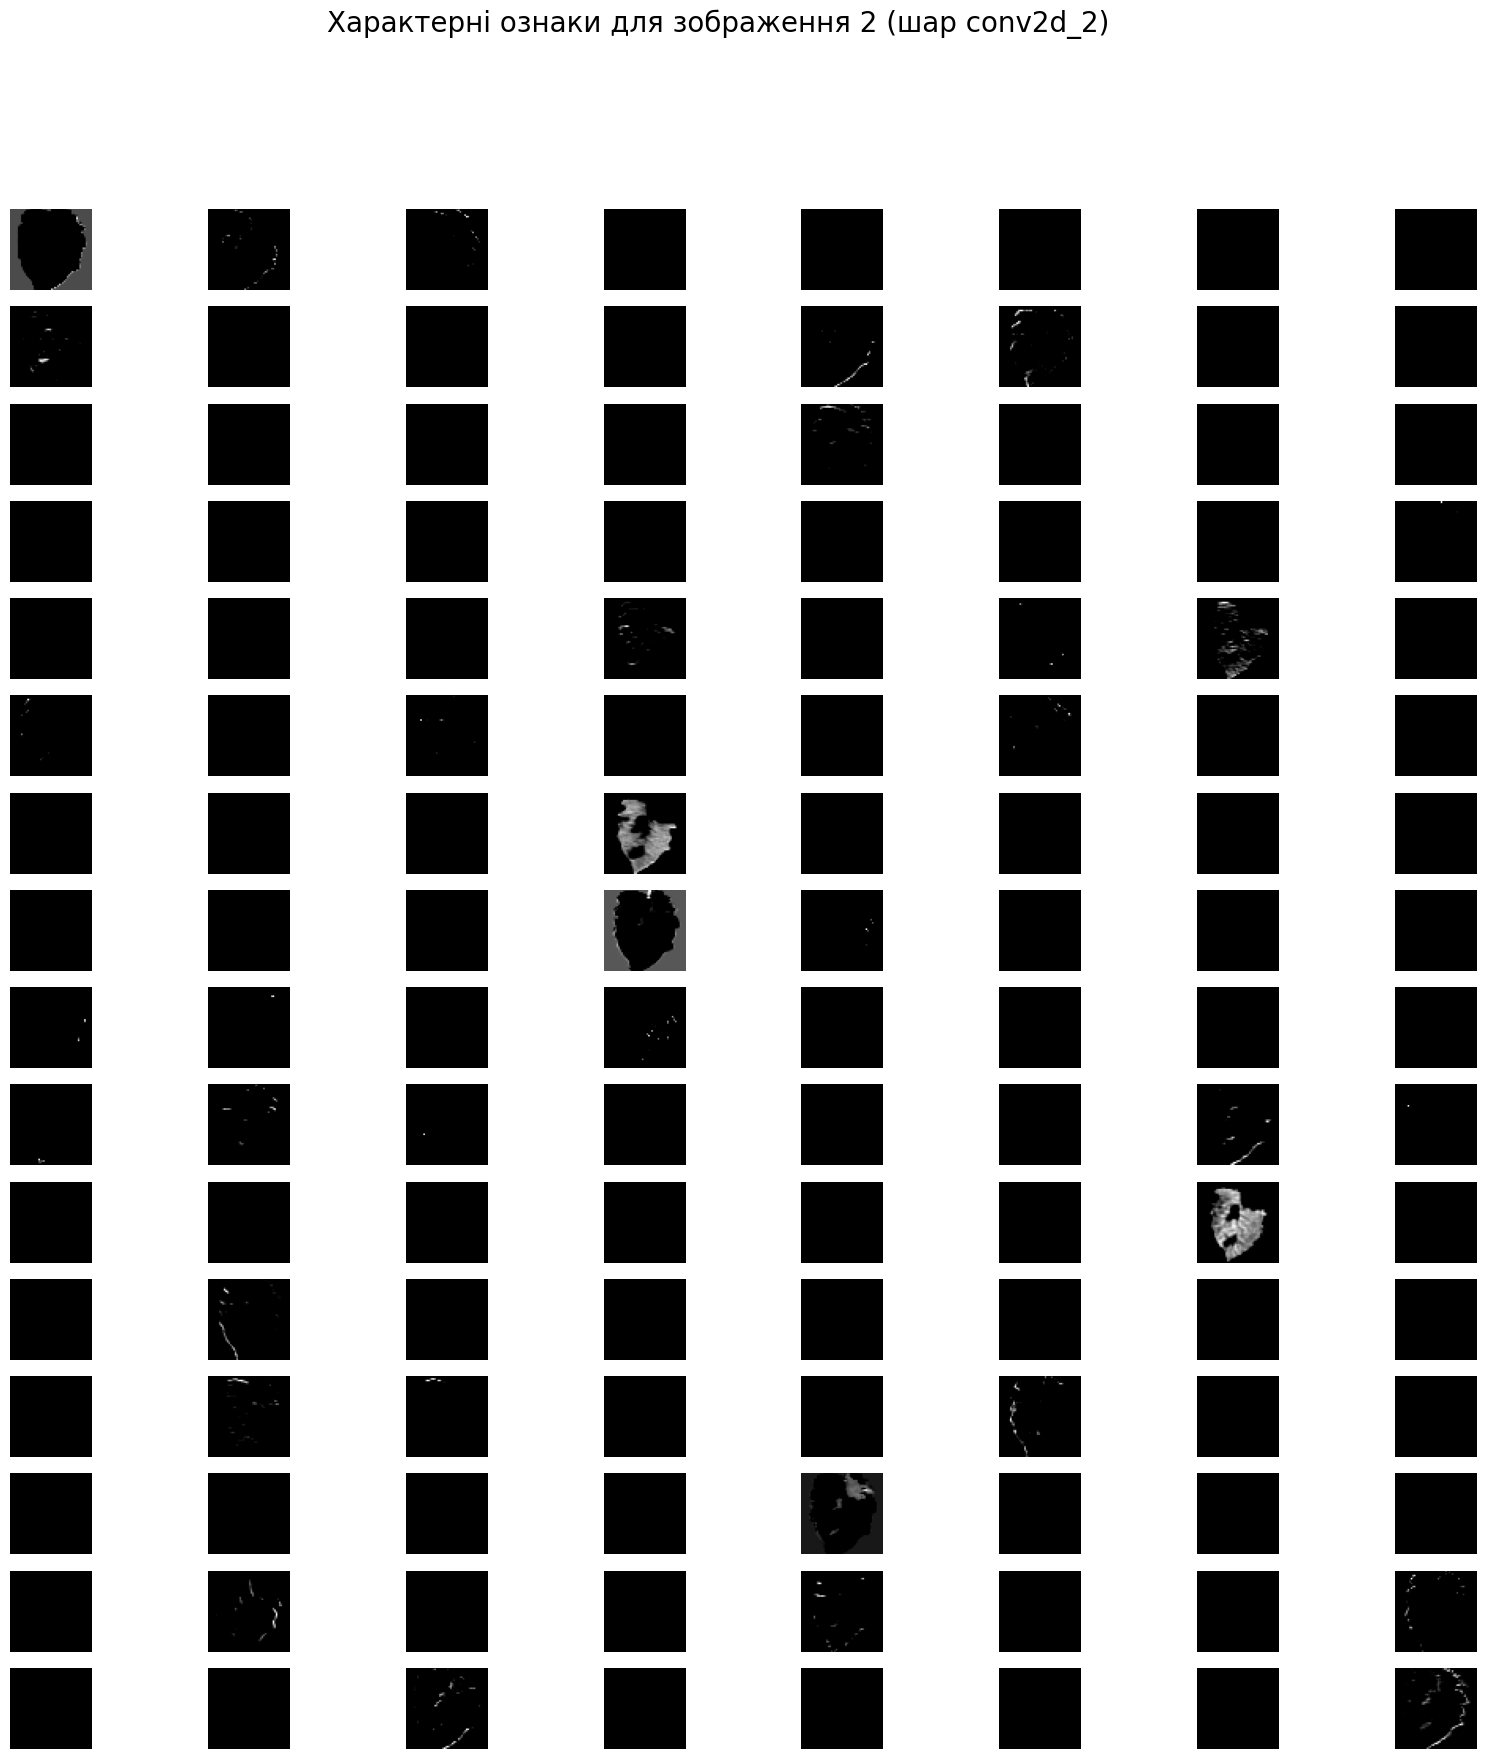

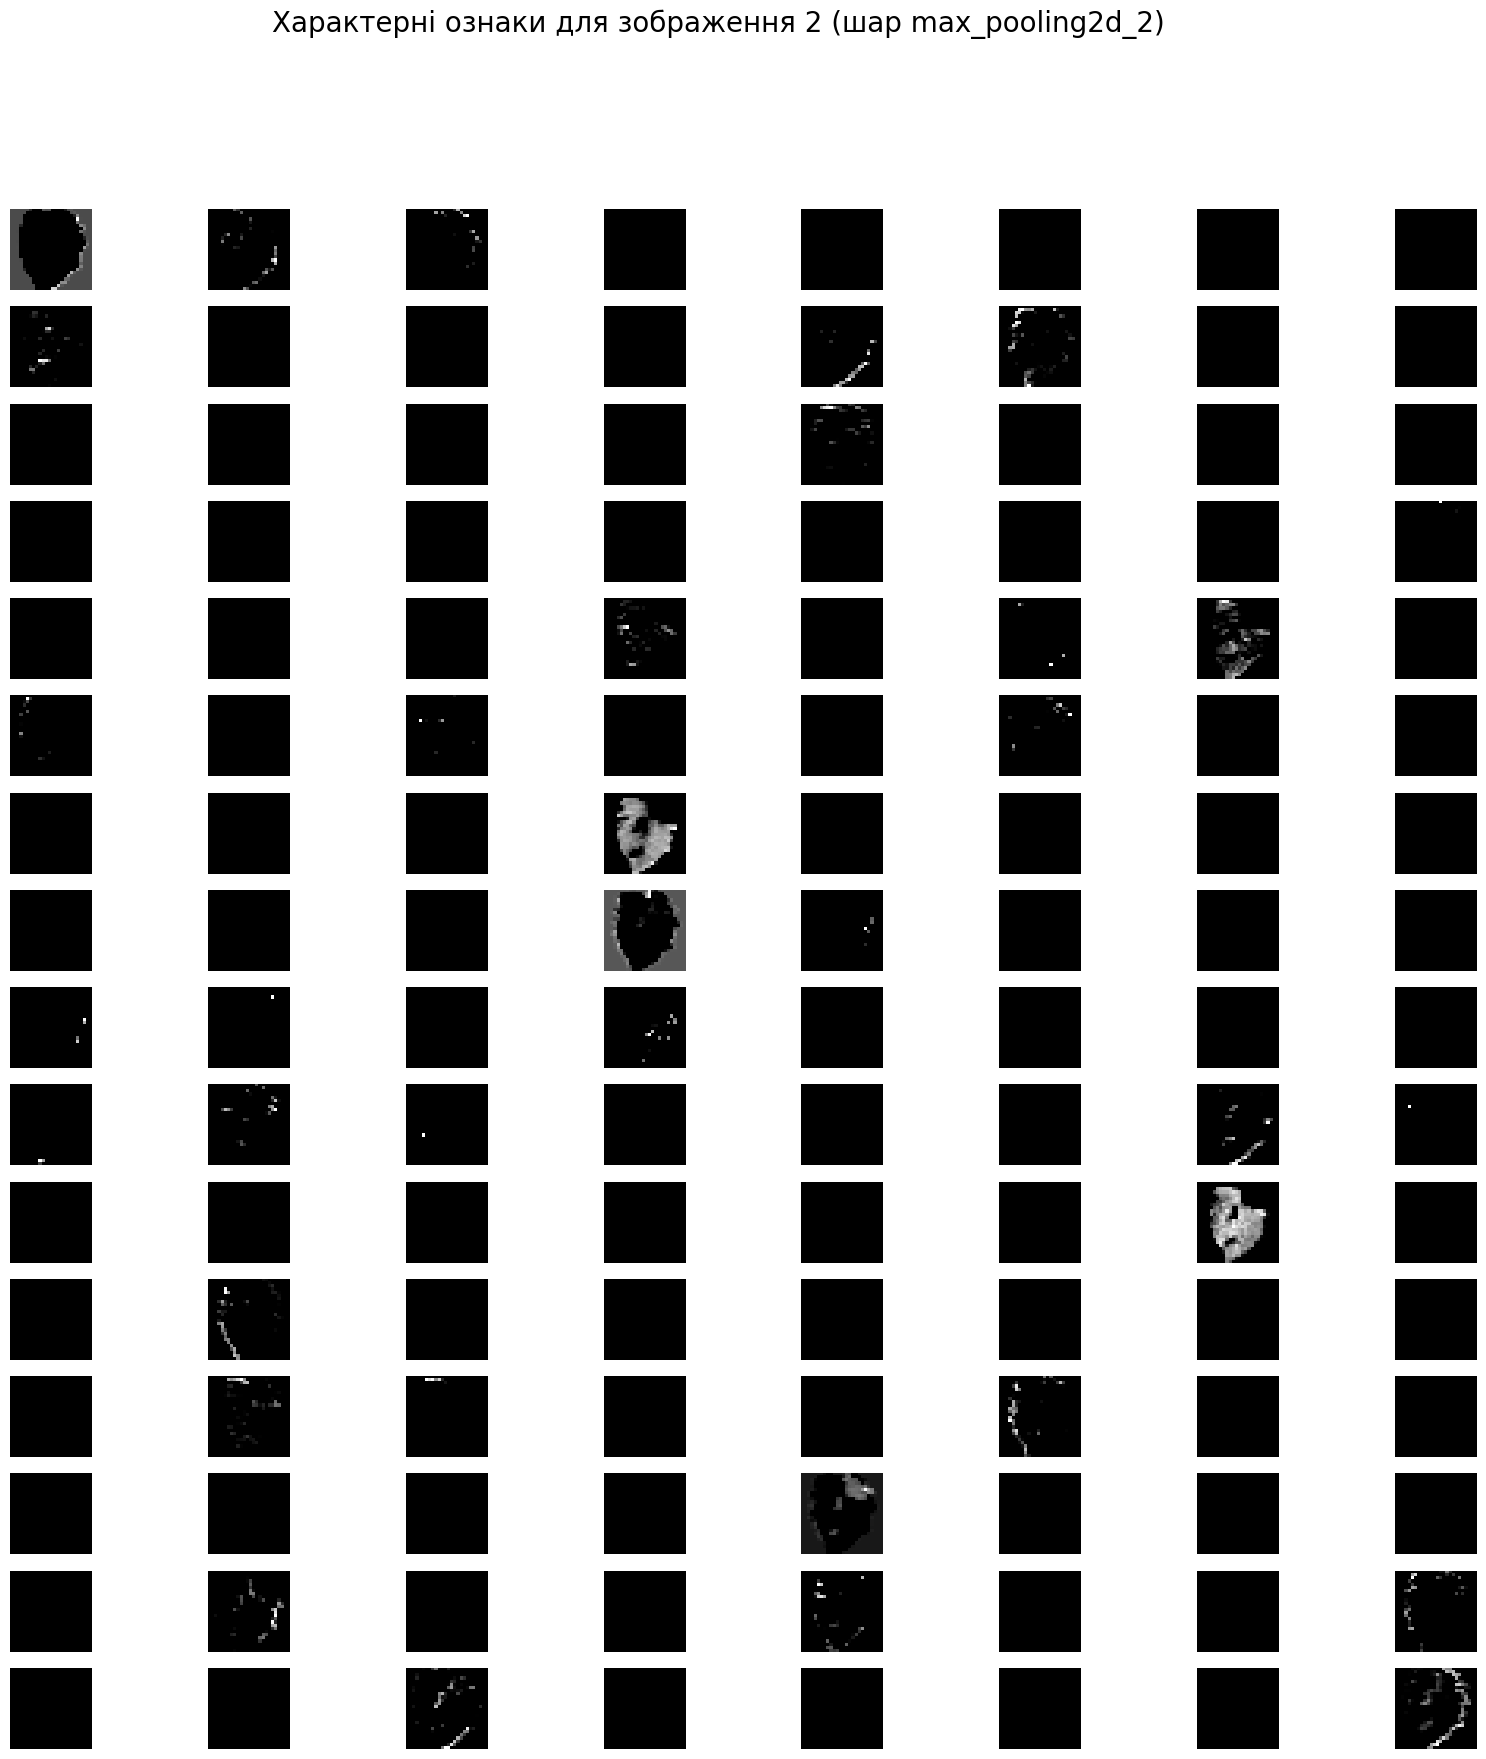

In [35]:
# Завантаження натренованої моделі
model = tf.keras.models.load_model('/content/trained_model.h5')

# Завантаження та підготовка зображень для прогнозування
image_path1 = '/content/test_image_1.JPG'
image_path2 = '/content/test_image_2.jpg'

# Завантаження зображень та зміна їх розміру
image1 = tf.keras.preprocessing.image.load_img(image_path1, target_size=(224, 224))
image1 = tf.keras.preprocessing.image.img_to_array(image1)
image1 = np.expand_dims(image1, axis=0)

image2 = tf.keras.preprocessing.image.load_img(image_path2, target_size=(224, 224))
image2 = tf.keras.preprocessing.image.img_to_array(image2)
image2 = np.expand_dims(image2, axis=0)

# Класифікація зображень
prediction1 = model.predict(image1)
prediction2 = model.predict(image2)

# Візуалізація характерних ознак при згортці зображень
layer_names = [layer.name for layer in model.layers]

#

# Візуалізація характерних ознак під час проходження через кожен шар моделі
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations1 = activation_model.predict(image1)
activations2 = activation_model.predict(image2)

for i, activation in enumerate(activations1):
    if activation.ndim == 4:
        fig, axs = plt.subplots(activation.shape[-1] // 8, 8, figsize=(20, 20))
        fig.suptitle(f"Характерні ознаки для зображення 1 (шар {layer_names[i]})", fontsize=20)

        for j, ax in enumerate(axs.flat):
            if j < activation.shape[-1]:
                ax.imshow(activation[0, :, :, j], cmap='gray')
            ax.axis('off')

        plt.show()

for i, activation in enumerate(activations2):
    if activation.ndim == 4:
        fig, axs = plt.subplots(activation.shape[-1] // 8, 8, figsize=(20, 20))
        fig.suptitle(f"Характерні ознаки для зображення 2 (шар {layer_names[i]})", fontsize=20)

        for j, ax in enumerate(axs.flat):
            if j < activation.shape[-1]:
                ax.imshow(activation[0, :, :, j], cmap='gray')
            ax.axis('off')

        plt.show()